In [22]:
AA_KEYS

['A',
 'R',
 'N',
 'D',
 'C',
 'Q',
 'E',
 'G',
 'H',
 'I',
 'L',
 'K',
 'M',
 'F',
 'P',
 'S',
 'T',
 'W',
 'Y',
 'V']

No GPU available, using the CPU instead.


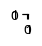

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

In [2]:
x = 'CEDAR_bootstrapped_df_cedar_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.csv'
key = 'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM'
key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8','aa_props')
key

'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM'

In [3]:
mut_cols = ['aliphatic_index','boman','hydrophobicity','isoelectric_point','VHSE1','VHSE3','VHSE7','VHSE8', 'icore_score','xd2']
key = '-'.join(mut_cols).replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8',
                            'aa_props')
if key == '':
    key = 'only_rank'
key = key.replace(' ', '-')
key

'aa_props-icore_score-xd2'

In [4]:
df=pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/gb_merged_wtrank.csv').set_index(['encoding','weight','pep_col','key'])

In [5]:
df.columns

Index(['mean_auc_CEDAR', 'mean_auc01_CEDAR', 'mean_AP_CEDAR', 'mean_auc_IBEL',
       'mean_auc01_IBEL', 'mean_AP_IBEL', 'mean_auc_NEPDB', 'mean_auc01_NEPDB',
       'mean_AP_NEPDB'],
      dtype='object')

In [6]:
df.sort_values('mean_auc_NEPDB', ascending=False).head()

mean_auc_CEDAR  \
encoding weight  pep_col   key                                                                  
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM        0.726024   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM        0.727488   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                  0.726254   
                           icore_dissimilarity_score-Total Peptide TPM               0.726093   
                           icore_dissimilarity_score-icore_mut_score-Total...        0.725832   

                                                                               mean_auc01_CEDAR  \
encoding weight  pep_col   key                                                                    
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM          0.576024   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM          0.575118   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                    0.576439   
                           icore_dissimilarity_score-Total Peptide TPM                 0.576535   
                           icore_dissimilarity_score-icore_mut_score-Total...          0.576204   

                                                                               mean_AP_CEDAR  \
encoding weight  pep_col   key                                                                 
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM       0.417796   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM       0.419221   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                 0.419809   
                           icore_dissimilarity_score-Total Peptide TPM              0.420283   
                           icore_dissimilarity_score-icore_mut_score-Total...       0.418912   

                                                                               mean_auc_IBEL  \
encoding weight  pep_col   key                                                                 
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM       0.540428   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM       0.549376   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                 0.527200   
                           icore_dissimilarity_score-Total Peptide TPM              0.529621   
                           icore_dissimilarity_score-icore_mut_score-Total...       0.526381   

                                                                               mean_auc01_IBEL  \
encoding weight  pep_col   key                                                                   
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM         0.498643   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM         0.498651   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                   0.498643   
                           icore_dissimilarity_score-Total Peptide TPM                0.498643   
                           icore_dissimilarity_score-icore_mut_score-Total...         0.502223   

                                                                               mean_AP_IBEL  \
encoding weight  pep_col   key                                                                
onehot   KL      icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM      0.271728   
         Shannon icore_mut icore_dissimilarity_score-Total Scaled Peptide TPM      0.274759   
         KL      icore_mut icore_dissimilarity_score-Total Gene TPM                0.267656   
                           icore_dissimilarity_score-Total Peptide TPM             0.268379   
                           icore_dissimilarity_score-icore_mut_score-Total...      0.270113   

      

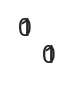

In [7]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [8]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

# init

## reloading datasets

In [9]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [ ]:
# Get dictionaries for lengths and HLA to know how many peps to query for each

In [ ]:
from itertools import product


In [29]:
pkl_dump((cedar_aligned.groupby('HLA').agg(c=('Peptide','count')).sort_values('c',ascending=False) / len(cedar_aligned)).to_dict()['c'], 'hla_dict.pkl', dirname='../../netmhcpan/')

../../netmhcpan/hla_dict.pkl saved.


In [74]:
for x in list(product(hladict.keys(), lendict.keys()))[190:]:
    print(x, math.floor(hladict[x[0]]* lendict[x[1]]))

('HLA-C1202', 11) 20
('HLA-C1202', 12) 0
('HLA-B5201', 9) 49
('HLA-B5201', 10) 28
('HLA-B5201', 11) 20
('HLA-B5201', 12) 0
('HLA-C1402', 9) 33
('HLA-C1402', 10) 19
('HLA-C1402', 11) 13
('HLA-C1402', 12) 0
('HLA-C0802', 9) 33
('HLA-C0802', 10) 19
('HLA-C0802', 11) 13
('HLA-C0802', 12) 0
('HLA-C0701', 9) 33
('HLA-C0701', 10) 19
('HLA-C0701', 11) 13
('HLA-C0701', 12) 0
('HLA-B3503', 9) 33
('HLA-B3503', 10) 19
('HLA-B3503', 11) 13
('HLA-B3503', 12) 0
('HLA-B5401', 9) 33
('HLA-B5401', 10) 19
('HLA-B5401', 11) 13
('HLA-B5401', 12) 0
('HLA-B1302', 9) 33
('HLA-B1302', 10) 19
('HLA-B1302', 11) 13
('HLA-B1302', 12) 0
('HLA-B4901', 9) 33
('HLA-B4901', 10) 19
('HLA-B4901', 11) 13
('HLA-B4901', 12) 0
('HLA-A0302', 9) 16
('HLA-A0302', 10) 9
('HLA-A0302', 11) 6
('HLA-A0302', 12) 0
('HLA-A0224', 9) 16
('HLA-A0224', 10) 9
('HLA-A0224', 11) 6
('HLA-A0224', 12) 0
('HLA-B3704', 9) 16
('HLA-B3704', 10) 9
('HLA-B3704', 11) 6
('HLA-B3704', 12) 0
('HLA-A6901', 9) 16
('HLA-A6901', 10) 9
('HLA-A6901', 11) 6
('H

In [50]:
cedar_aligned.EL_rank_mut.describe()

count    3033.000000
mean        1.245269
std         2.362419
min         0.000600
25%         0.127600
50%         0.490700
75%         1.478700
max        44.333300
Name: EL_rank_mut, dtype: float64

In [40]:
import math
lendict = (cedar_aligned.groupby('len').agg(c=('Peptide','count')) / len(cedar_aligned) * 100000).to_dict()['c']
lendict = {k:math.ceil(v) for k,v in lendict.items()}
pkl_dump(lendict, 'len_dict.pkl', dirname='../../netmhcpan/')

../../netmhcpan/len_dict.pkl saved.


## Baselines

3480


0.5784313725490196

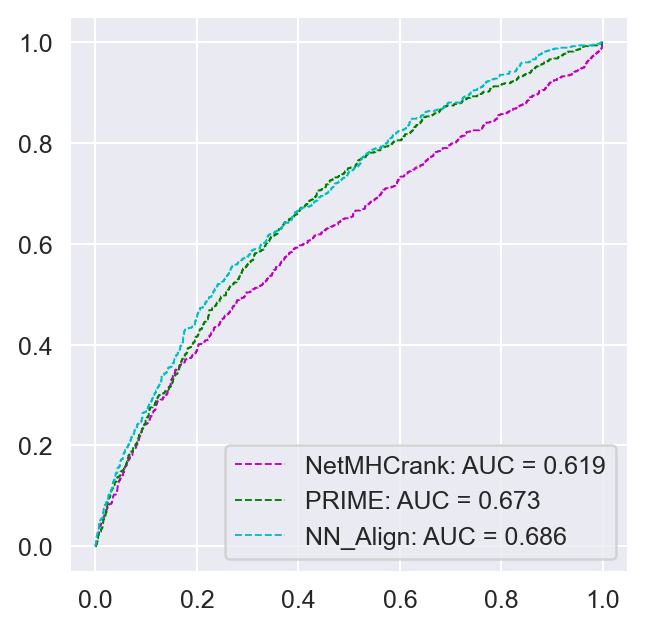

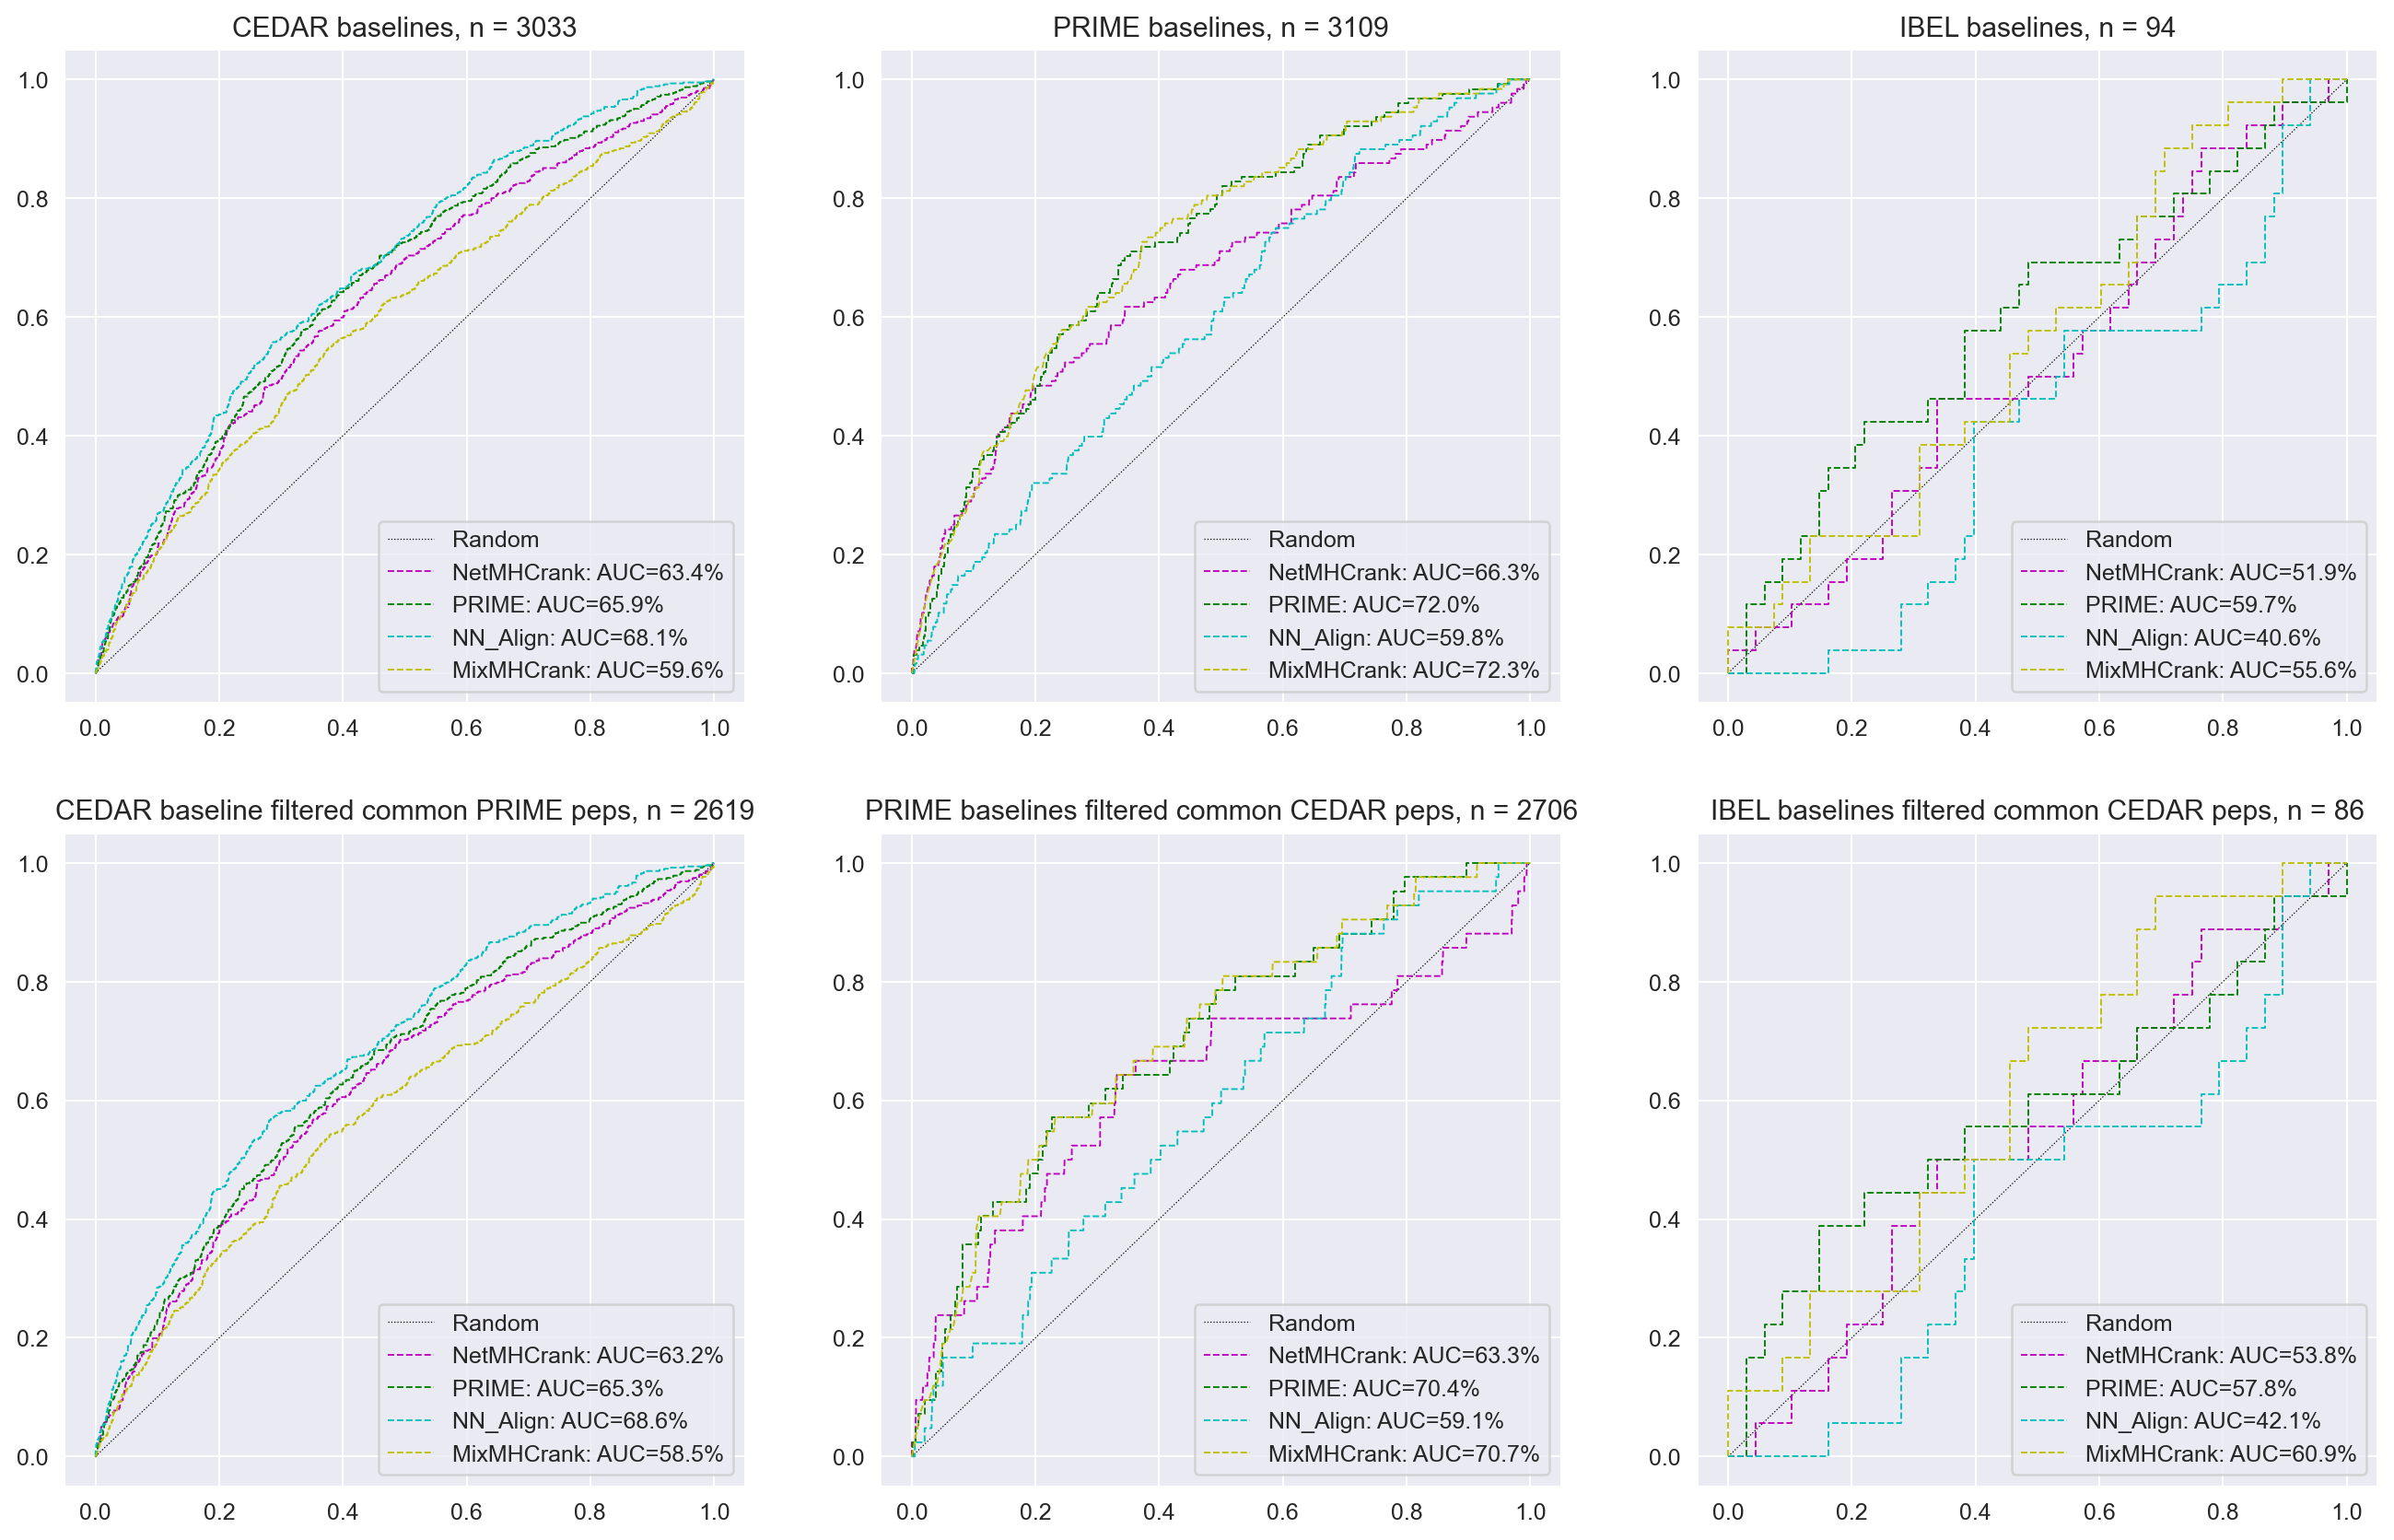

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

from src.baselines import plot_related_baseline_roc
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

In [6]:
from src.metrics import get_metrics
from sklearn.metrics import matthews_corrcoef

In [7]:
np.linspace(0.05, .95, 25)

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.2375, 0.275 , 0.3125,
       0.35  , 0.3875, 0.425 , 0.4625, 0.5   , 0.5375, 0.575 , 0.6125,
       0.65  , 0.6875, 0.725 , 0.7625, 0.8   , 0.8375, 0.875 , 0.9125,
       0.95  ])

In [8]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    return best[0], best[1]

# Example
preds_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/raw/cedar_preds_onehot_None_icore_mut_EL_rank_mut_aa_props.csv')

t_list = []
mcc_list = []
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    
np.mean(mcc_list), np.mean(t_list)


Current fold : 0
	Best : Threshold= 0.350, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.275, MCC= 0.298

Current fold : 2
	Best : Threshold= 0.162, MCC= 0.154

Current fold : 3
	Best : Threshold= 0.200, MCC= 0.323

Current fold : 4
	Best : Threshold= 0.275, MCC= 0.453

Current fold : 5
	Best : Threshold= 0.200, MCC= 0.382

Current fold : 6
	Best : Threshold= 0.387, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.237, MCC= 0.325

Current fold : 8
	Best : Threshold= 0.312, MCC= 0.286

Current fold : 9
	Best : Threshold= 0.312, MCC= 0.277


(0.31972651124419793, 0.27125000000000005)

In [9]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.ensemble import RandomForestClassifier

cedar_trainset = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_evalset = pd.read_csv('../data/mutant/221117_prime_related_newcore_fold.csv')
ibel_evalset = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')

_, aa_cols = get_aa_properties(cedar_trainset.sample(1))
# Shannon for first 3
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['dissimilarity_score', 'blsm_mut_score'])

for k, ics_dict, best_kwargs in zip(['Compromise'],
                                   [ics_kl],
                                   [best_agg]):
    
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)
    
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_trainset, model, ics_dict, best_kwargs, n_jobs=8)
    kcv_preds, _ = evaluate_trained_models_sklearn(cedar_trainset, trained_models, ics_dict, train_dataframe=cedar_trainset,
                                                encoding_kwargs = best_kwargs, concatenated = False, n_jobs=8)
    break

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
def threshold_pred(df, thresholds, predcol, targetcol):
    df = df.copy()
    df['predicted_label'] = np.nan
    for k in df.fold.unique():
        tmp = df.query('fold==@k')
        preds = (tmp[predcol]>=thresholds[k]).astype(int)
        df.loc[tmp.index, 'predicted_label'] = preds
    return df

thresholds = {}
for f in sorted(preds_df.fold.unique()):
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 50, 'pred', 'agg_label')
    thresholds[f] = t
thresholded_df = threshold_pred(preds_df, thresholds, 'pred', 'agg_label')


Current fold : 0
	Best : Threshold= 0.344, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.289, MCC= 0.312

Current fold : 2
	Best : Threshold= 0.160, MCC= 0.172

Current fold : 3
	Best : Threshold= 0.215, MCC= 0.318

Current fold : 4
	Best : Threshold= 0.270, MCC= 0.446

Current fold : 5
	Best : Threshold= 0.215, MCC= 0.388

Current fold : 6
	Best : Threshold= 0.381, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.252, MCC= 0.312

Current fold : 8
	Best : Threshold= 0.289, MCC= 0.308

Current fold : 9
	Best : Threshold= 0.307, MCC= 0.277


In [11]:
from sklearn.metrics import precision_score, f1_score, recall_score
print('per fold thresholding\n', 
      f"F1:\t{round(f1_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nPrec:\t{round(precision_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nRecall:\t{round(recall_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}")
print('\nmean_thresholding\n', 
      f"F1:\t{round(f1_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nPrec:\t{round(precision_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nRecall:\t{round(recall_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}")

per fold thresholding
 F1:	0.4557 
Prec:	0.3974 
Recall:	0.5341 
MCC:	0.2906


KeyError: 'agg_label'

## checks

In [ ]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    threshold, mccoef = best[0], best[1]
    return threshold, mccoef

In [ ]:
compromise = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')

t_list = []
mcc_list = []
new_preds = preds_df.copy()
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    print(preds_df.query('fold==@f').pred.median())
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    idx = new_preds.query('fold==@f').index
    new_preds.loc[idx, 'pred']=new_preds.loc[idx,'pred']-t
np.mean(mcc_list), np.mean(t_list)

In [ ]:
roc_auc_score(new_preds['agg_label'], new_preds['pred']), roc_auc_score(preds_df['agg_label'], preds_df['pred'])

In [ ]:
f,a = plt.subplots(len(compromise.fold.unique()), 1, figsize=(10, 5*len(compromise.fold.unique())))
compromise.groupby(['fold'])['mean_pred'].plot(kind='hist', alpha=0.75, bins=60)

## Retrain model

In [46]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')

In [47]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total Gene TPM'])

best_models_retrained = {}

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)

trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model, None, best_agg, n_jobs=8)
cv_metrics, cv_preds = evaluate_trained_models_sklearn(cedar_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg)
metrics, preds = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=True, encoding_kwargs=best_agg)

metrics_mean, preds_mean = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=False, only_concat=False, encoding_kwargs=best_agg)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
roc_auc_score(preds['agg_label'], preds['pred']), roc_auc_score(preds_mean['agg_label'], preds_mean['mean_pred'])

In [ ]:
from src.utils import get_palette
sns.set_palette(get_palette('viridis', n_colors=10))
cv_preds.groupby('fold')['pred'].plot(kind='hist', alpha=0.75, bins = 100, legend=True)
pd.set_option('display.max_columns',40)
cv_preds[['HLA','agg_label','fold','Peptide','pred']].groupby('fold')['agg_label','pred'].describe(percentiles = [.1, .25, .5, .75, .8, .9, .95])

In [ ]:


print('For CEDAR KCV')
for k in metrics:
    print(k, round(cv_metrics[k]['auc'],3), round(cv_metrics[k]['auc_01'],3), round(cv_metrics[k]['AP'],3))
    
cv_mean_xd = preds.groupby(['Peptide','agg_label','HLA'])[['pred']].mean().reset_index()
print('mean', round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred']),3), round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred'], max_fpr=0.1),3), round(average_precision_score(mean_xd['agg_label'], mean_xd['pred']),3)) 


print('For prime aligned')
for k in metrics:
    print(k, round(metrics[k]['auc'],3), round(metrics[k]['auc_01'],3), round(metrics[k]['AP'],3))
    
mean_xd = preds.groupby(['Peptide','agg_label','HLA'])[['pred']].mean().reset_index()
print('mean', round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred']),3), round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred'], max_fpr=0.1),3), round(average_precision_score(mean_xd['agg_label'], mean_xd['pred']),3)) 



## checks

In [23]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total Gene TPM'])

def print_stuff(labels, scores, threshold):
    mcc_notune = matthews_corrcoef(labels, scores>0.19)
    prec_notune = precision_score(labels, scores>0.19)
    rec_notune = recall_score(labels, scores>0.19)
    acc_notune = balanced_accuracy_score(labels, scores>0.19)
    f1_notune = f1_score(labels, scores>0.19)
    mcc_tuned = matthews_corrcoef(labels, scores>threshold)
    prec_tuned = precision_score(labels, scores>threshold)
    rec_tuned = recall_score(labels, scores>threshold)
    acc_tuned = balanced_accuracy_score(labels, scores>threshold)
    f1_tuned = f1_score(labels, scores>threshold)
    # mcc_diff = mcc_tuned-mcc_notune
    # prec_diff = prec_tuned-prec_notune
    # rec_diff = rec_tuned-rec_notune
    # f1_diff = f1_tuned-f1_notune
    # acc_diff = acc_tuned-acc_notune
    print(f'No tune (T=0.19): \tMCC={mcc_notune:.3f}, prec={prec_notune:.2%}, recall={rec_notune:.2%}, f1={f1_notune:.2%}, acc={acc_notune:.2%}')
    print(f'Best : T={threshold:.3f}, \tMCC={mcc_tuned:.3f}, prec={prec_tuned:.2%}, recall={rec_tuned:.2%}, f1={f1_tuned:.2%}, acc={acc_tuned:.2%}')
    # print(f'Best threshold={threshold:.3f}, \t∂MCC= {mcc_diff:.2%}, ∂prec= {prec_diff:.2%}, ∂rec= {rec_diff:.2%}, ∂F1= {f1_diff:.2%}, ∂Acc= {acc_diff:.2%}')
    
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    
    for t in thresholds:
        preds = scores > t
        results[t] = f1_score(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    threshold, best_score = best[0], best[1]
    print_stuff(labels,scores,threshold)
    return threshold, best_score

In [24]:
for f in sorted(cv_preds.fold.unique()):
    print('Fold: ',f)
    tune_threshold(cv_preds.query('fold==@f'))
print('Concat:')
tune_threshold(cv_preds)

NameError: name 'cv_preds' is not defined

In [ ]:
import copy
kwargs = copy.deepcopy(best_agg)
res = {}

folds = sorted(cv_preds.fold.unique())
concat = []
for outer_fold in folds:
    for i, inner_fold in enumerate(sorted([f for f in folds if f != outer_fold])):
        df = cv_preds.query('fold==@inner_fold')
        x, y = get_dataset(df, None, **kwargs)
        model = trained_models[outer_fold][i]
        res[i] = pd.DataFrame(np.array([y, model.predict_proba(x)[:, 1]]).T, columns=['agg_label', 'pred'])
        print('\nFolds: ', outer_fold, inner_fold)
        tune_threshold(res[i], n_points=50)
        concat.append(res[i])
print('CONCAT')
tune_threshold(pd.concat(concat), n_points=50)

# Redo with two methods and classes

## Retrain model

In [6]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')

In [7]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total Gene TPM'])

best_models_retrained = {}

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)

trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model, None, best_agg, n_jobs=8)
cv_metrics, cv_preds = evaluate_trained_models_sklearn(cedar_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg)
metrics, preds = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=True, encoding_kwargs=best_agg)

metrics_mean, preds_mean = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=False, only_concat=False, encoding_kwargs=best_agg)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
def get_scores(scores, labels, threshold=0.5):
    results={}
    results['auc'] = round(roc_auc_score(labels, scores), 4)
    results['auc01'] = round(roc_auc_score(labels, scores, max_fpr=0.1), 4)
    results['ap'] = round(average_precision_score(labels, scores), 4)
    preds = scores>threshold
    results['balanced_acc'] = round(balanced_accuracy_score(labels, preds), 4)
    results['acc'] = round(accuracy_score(labels, preds), 4)
    results['prec'] = round(precision_score(labels, preds), 4)
    results['rec'] = round(recall_score(labels, preds), 4)
    results['f1'] = round(recall_score(labels, preds), 4)
    fpr, tpr, _ = roc_curve(labels, scores)
    rocs = (fpr,tpr)
    return results, rocs

In [ ]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing

class OuterFoldWrapper():
    def __init__(self, models_dict, train_df, scoring):
        self.models = models_dict
        self.train_df = train_df
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        
    def tune_threshold(self, df, n_points=100, predcol='pred', labelcol = 'agg_label'):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = df[predcol].values
        labels = df[labelcol].values        
        results = {t:self.scoring(labels, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        
        return threshold, score

    def tune_all_thresholds(self, n_points=100, predcol='pred', target_col='agg_label'):
        # This is done using outerfold and all models in inner fold, i.e. doesn't need the x,y but only 
        for fold in self.models:
            threshold, score = self.tune_threshold(self.train_df.query('fold==@fold'), n_points, predcol, target_col)
            self.thresholds[fold] = threshold
            self.scores[fold] = score
        self.tuned=True
            
        
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([(np.mean(([model.predict_proba(x)[:, 1] for model in self.models[k]]), axis=0)>self.thresholds[k]).astype(int) for k in self.models], axis=0)

    
class AllFoldWrapper():
    def __init__(self, models_dict, train_df, ics_dict,  kwargs, scoring, cores=multiprocessing.cpu_count()):
        self.models = models_dict
        self.train_df = train_df
        self.folds = sorted(train_df.fold.unique())
        self.ics_dict = ics_dict
        self.kwargs = kwargs
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        self.max_cores = cores
        
    def tune_threshold(self, model, x, y, n_points=100):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = model.predict_proba(x)[:, 1]
        results = {t:self.scoring(y, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        return threshold, score
    
    def parallel_wrapper(self, outer_fold, inner_fold, inner_fold_index, n_points=100):
        model = self.models[outer_fold][inner_fold_index]
        x,y = get_dataset(self.train_df.query('fold==@inner_fold'), self.ics_dict, **self.kwargs)
        return self.tune_threshold(model=model, x=x, y=y, n_points=n_points)
    
    def tune_all_thresholds(self, n_points=100, n_jobs=8):
        for outer_fold in tqdm(self.folds, desc='Tuning thresholds: outer fold', leave=False):
            inner_folds = sorted([f for f in self.folds if f!=outer_fold])
            wrapper = partial(self.parallel_wrapper, outer_fold = outer_fold, n_points = n_points)
            output = Parallel(n_jobs=min(n_jobs, self.max_cores))(delayed(wrapper)(inner_fold = fold, inner_fold_index=i) for i, fold in enumerate(inner_folds))
            self.thresholds[outer_fold] = [x[0] for x in output]
            self.scores[outer_fold] = [x[1] for x in output]
        
        self.tuned=True
            
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([np.mean([model.predict_proba(x)[:, 1]>self.thresholds[k][i] for i, model in enumerate(self.models[k])], axis=0) for k in self.models], axis=0)

In [9]:
best_agg['standardize']=True

results_prime = {}
results_nepdb = {}
rocs_prime = {}
rocs_nepdb = {}


In [11]:
_, preds_prime = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg, n_jobs=8)
_, preds_nepdb = evaluate_trained_models_sklearn(nepdb_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg, n_jobs=8)
metrics_prime, rocs_prime_ = get_scores(preds_prime['pred'].values, preds_prime['agg_label'].values, threshold=0.19)
metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb['pred'].values, preds_nepdb['agg_label'].values, threshold=0.19)
results_prime['notune_concat'] = metrics_prime
results_nepdb['notune_concat'] = metrics_nepdb
rocs_prime['notune_concat'] = rocs_prime_
rocs_nepdb['notune_concat'] = rocs_nepdb_

_, preds_prime = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=False, encoding_kwargs=best_agg, n_jobs=8)
_, preds_nepdb = evaluate_trained_models_sklearn(nepdb_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=False, encoding_kwargs=best_agg, n_jobs=8)

metrics_prime, rocs_prime_ = get_scores(preds_prime['mean_pred'].values, preds_prime['agg_label'].values, threshold=0.19)
metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb['mean_pred'].values, preds_nepdb['agg_label'].values, threshold=0.19)
results_prime['notune_mean']= metrics_prime
results_nepdb['notune_mean']= metrics_nepdb
rocs_prime['notune_mean'] = rocs_prime_
rocs_nepdb['notune_mean'] = rocs_nepdb_



Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

## tune-wrapper

In [19]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing

class OuterFoldWrapper():
    def __init__(self, models_dict, train_df, scoring):
        self.models = models_dict
        self.train_df = train_df
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        
    def tune_threshold(self, df, n_points=100, predcol='pred', labelcol = 'agg_label'):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = df[predcol].values
        labels = df[labelcol].values        
        results = {t:self.scoring(labels, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        
        return threshold, score

    def tune_all_thresholds(self, n_points=100, predcol='pred', target_col='agg_label'):
        # This is done using outerfold and all models in inner fold, i.e. doesn't need the x,y but only 
        for fold in self.models:
            threshold, score = self.tune_threshold(self.train_df.query('fold==@fold'), n_points, predcol, target_col)
            self.thresholds[fold] = threshold
            self.scores[fold] = score
        self.tuned=True
            
        
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([(np.mean(([model.predict_proba(x)[:, 1] for model in self.models[k]]), axis=0)>self.thresholds[k]).astype(int) for k in self.models], axis=0)

    
class AllFoldWrapper():
    def __init__(self, models_dict, train_df, ics_dict,  kwargs, scoring, cores=multiprocessing.cpu_count()):
        self.models = models_dict
        self.train_df = train_df
        self.folds = sorted(train_df.fold.unique())
        self.ics_dict = ics_dict
        self.kwargs = kwargs
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        self.max_cores = cores
        
    def tune_threshold(self, model, x, y, n_points=100):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = model.predict_proba(x)[:, 1]
        results = {t:self.scoring(y, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        return threshold, score
    
    def parallel_wrapper(self, outer_fold, inner_fold, inner_fold_index, n_points=100):
        model = self.models[outer_fold][inner_fold_index]
        x,y = get_dataset(self.train_df.query('fold==@inner_fold'), self.ics_dict, **self.kwargs)
        return self.tune_threshold(model=model, x=x, y=y, n_points=n_points)
    
    def tune_all_thresholds(self, n_points=100, n_jobs=8):
        for outer_fold in tqdm(self.folds, desc='Tuning thresholds: outer fold', leave=False):
            inner_folds = sorted([f for f in self.folds if f!=outer_fold])
            wrapper = partial(self.parallel_wrapper, outer_fold = outer_fold, n_points = n_points)
            output = Parallel(n_jobs=min(n_jobs, self.max_cores))(delayed(wrapper)(inner_fold = fold, inner_fold_index=i) for i, fold in enumerate(inner_folds))
            self.thresholds[outer_fold] = [x[0] for x in output]
            self.scores[outer_fold] = [x[1] for x in output]
        
        self.tuned=True
            
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([np.mean([model.predict_proba(x)[:, 1]>self.thresholds[k][i] for i, model in enumerate(self.models[k])], axis=0) for k in self.models], axis=0)

In [51]:
import copy
kwargs = copy.deepcopy(best_agg)
kwargs.pop('standardize')
for wrapper, method in zip([OuterFoldWrapper, AllFoldWrapper],['OuterFold', 'AllFolds']):
    print(method)
    for scoring,nm in zip([matthews_corrcoef, f1_score, balanced_accuracy_score, precision_score],['MCC', 'F1', 'Balanced_acc', 'Precision']):
        if method == 'OuterFold':
            test = OuterFoldWrapper(trained_models, cv_preds, scoring)
            test.tune_all_thresholds(n_points=100)
        elif method == 'AllFolds':
            test = AllFoldWrapper(trained_models, cv_preds, None, kwargs, scoring)
            test.tune_all_thresholds(n_points=100, n_jobs=7)
        print(nm)
        
        x_prime, y_prime = get_dataset(prime_expr, None, **kwargs)
        preds_prime = test.predict_proba(x_prime)
        metrics_prime, rocs_prime_ = get_scores(preds_prime, y_prime)
        
        x_nepdb, y_nepdb = get_dataset(nepdb_expr, None, **kwargs)
        preds_nepdb = test.predict_proba(x_nepdb)
        metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb, y_nepdb)
        
        results_prime[method+'_by_'+nm] = metrics_prime
        rocs_prime[method+'_by_'+nm] = rocs_prime_
        results_nepdb[method+'_by_'+nm] = metrics_nepdb
        rocs_nepdb[method+'_by_'+nm] = rocs_nepdb_

OuterFold
MCC
F1
Balanced_acc
Precision
AllFolds


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

MCC


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

F1


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Balanced_acc


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Precision


## checks from preds / prev results

In [12]:
gb_merged=pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/gb_merged.csv')
gb_merged.set_index(['encoding','weight', 'key','pep_col'], inplace=True)

In [13]:
gb_merged.sort_values('mean_precision_PRIME', ascending=False).head()

experiment  \
encoding weight  key                                                pep_col                            
onehot   Shannon Total Gene TPM                                     icore_mut  aligned_expr_mutscore   
         None    Total Peptide TPM                                  icore_mut  aligned_expr_mutscore   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut  aligned_expr_mutscore   
                 core_mutation_score-Total Gene TPM                 icore_mut   normal_expr_mutscore   
                 icore_mut_score-Total Gene TPM                     icore_mut  aligned_expr_mutscore   

                                                                               mean_auc_CEDAR  \
encoding weight  key                                                pep_col                     
onehot   Shannon Total Gene TPM                                     icore_mut        0.727530   
         None    Total Peptide TPM                                  icore_mut        0.725230   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut        0.727256   
                 core_mutation_score-Total Gene TPM                 icore_mut        0.726925   
                 icore_mut_score-Total Gene TPM                     icore_mut        0.727225   

                                                                               mean_precision_CEDAR  \
encoding weight  key                                                pep_col                           
onehot   Shannon Total Gene TPM                                     icore_mut              0.876059   
         None    Total Peptide TPM                                  icore_mut              0.503176   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut              0.999700   
                 core_mutation_score-Total Gene TPM                 icore_mut              1.000000   
                 icore_mut_score-Total Gene TPM                     icore_mut              0.999900   

                                                                               mean_auc_PRIME  \
encoding weight  key                                                pep_col                     
onehot   Shannon Total Gene TPM                                     icore_mut        0.696006   
         None    Total Peptide TPM                                  icore_mut        0.695849   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut        0.701861   
                 core_mutation_score-Total Gene TPM                 icore_mut        0.693879   
                 icore_mut_score-Total Gene TPM                     icore_mut        0.691749   

                                                                               mean_precision_PRIME  \
encoding weight  key                                                pep_col                           
onehot   Shannon Total Gene TPM                                     icore_mut                0.6311   
         None    Total Peptide TPM                                  icore_mut                0.6311   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut                0.6311   
                 core_mutation_score-Total Gene TPM                 icore_mut                0.6311   
                 icore_mut_score-Total Gene TPM                     icore_mut                0.6311   

                                                                               mean_auc_IBEL  \
encoding weight  key                                                pep_col                    
onehot   Shannon Total Gene TPM                                     icore_mut       0.526269   
         None    Total Peptide TPM                                  icore_mut       0.519655   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut       0.554426   
                 core_mutation_score-Total Gene TPM                 icore_mut

In [14]:
gb_merged.sort_values('Compromise', ascending=False).head()

experiment  \
encoding weight        key                                                pep_col                            
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   

                                                                                     mean_auc_CEDAR  \
encoding weight        key                                                pep_col                     
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.727096   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.728096   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.727685   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.726988   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.726896   

                                                                                     mean_precision_CEDAR  \
encoding weight        key                                                pep_col                           
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.574228   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.430404   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.503432   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.668514   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.728557   

                                                                                     mean_auc_PRIME  \
encoding weight        key                                                pep_col                     
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.715249   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712474   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712129   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712271   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712369   

                                                                                     mean_precision_PRIME  \
encoding weight        key                                                pep_col                           
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.630900   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.435577   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.435577   

                                                                                     mean_auc_IBEL  \
encoding weight        key                                                pep_col                    
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut       0.558364   
                       icore_dissimilarity_scor

In [15]:
%ls ../output/230125_aligned_icore_exprscore_mutscore/raw/ | grep "CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM" | head

CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM.csv


In [16]:
cdt_comp = '_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM'
cdt_prime_prec = '_cedar_onehot_Shannon_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_mut_score-Total Scaled Peptide TPM'

In [17]:
dir_ = '../output/230125_aligned_icore_exprscore_mutscore/raw/'
cedar_preds_comp = pd.read_csv(f'{dir_}CEDAR_preds{cdt_comp}.csv')
prime_preds_comp = pd.read_csv(f'{dir_}PRIME_preds{cdt_comp}.csv')
nepdb_preds_comp = pd.read_csv(f'{dir_}NEPDB_preds{cdt_comp}.csv')

cedar_preds_prime_prec = pd.read_csv(f'{dir_}CEDAR_preds{cdt_prime_prec}.csv')
prime_preds_prime_prec = pd.read_csv(f'{dir_}PRIME_preds{cdt_prime_prec}.csv')
nepdb_preds_prime_prec = pd.read_csv(f'{dir_}NEPDB_preds{cdt_prime_prec}.csv')



In [20]:
rename_map = {'ap':'Average Precision', 'balanced_acc':'Balanced Accuracy', 'acc':'Accuracy',
              'prec':'Precision / PPV', 'rec':'Recall / TPR', 'f1':'F1 score', 'auc':'AUC', 'auc01':'AUC0.1'}
def rename_metric(metric):
    return rename_map[metric]

res = {}
for preds, name in zip([cedar_preds_comp,prime_preds_comp,nepdb_preds_comp,cedar_preds_prime_prec,prime_preds_prime_prec,nepdb_preds_prime_prec],
                       ['cedar_compromise', 'prime_compromise', 'nepdb_compromise', 'cedar_PP', 'prime_PP', 'nepdb_PP']):
    c = 'mean_pred' if 'mean_pred' in preds.columns else 'pred'
    for t in [0.5, 0.19]:
        sc, _ = get_scores(preds[c], preds['agg_label'], t)
        res[f'{name}_{t}'] = sc
comparison_df = pd.DataFrame(res).T
comparison_df.columns = map(rename_metric, comparison_df.columns)
comparison_df

,AUC,AUC0.1,Average Precision,Balanced Accuracy,Accuracy,Precision / PPV,Recall / TPR,F1 score
cedar_compromise_0.5,0.7279,0.5767,0.4153,0.5016,0.7912,0.4286,0.0048,0.0048
cedar_compromise_0.19,0.7279,0.5767,0.4153,0.6617,0.5974,0.3119,0.7721,0.7721
prime_compromise_0.5,0.7125,0.5780,0.0827,0.5000,0.9842,0.0000,0.0000,0.0000
prime_compromise_0.19,0.7125,0.5780,0.0827,0.6221,0.5160,0.0236,0.7317,0.7317
nepdb_compromise_0.5,0.7475,0.6035,0.3220,0.5000,0.9181,0.0000,0.0000,0.0000
nepdb_compromise_0.19,0.7475,0.6035,0.3220,0.5825,0.4095,0.1014,0.7895,0.7895
cedar_PP_0.5,0.7272,0.5747,0.4185,0.5064,0.7942,1.0000,0.0128,0.0128
cedar_PP_0.19,0.7272,0.5747,0.4185,0.6675,0.6027,0.3162,0.7785,0.7785
prime_PP_0.5,0.7020,0.5857,0.0842,0.5242,0.9846,0.6667,0.0488,0.0488
prime_PP_0.19,0.7020,0.5857,0.0842,0.6377,0.5230,0.0247,0.7561,0.7561


In [82]:
prime_preds_prime_prec.loc[[678, 679],['Peptide', 'trueHLA_EL_rank']]

,Peptide,trueHLA_EL_rank
678,GLFGDIYLA,0.0523
679,GLFGDIYLAI,0.3693


In [80]:
prime_preds_prime_prec.sort_values('mean_pred', ascending=False).head(10)

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,Total Peptide TPM,Total Scaled Peptide TPM,Total Gene TPM,mean_pred
678,HLA-A0201,0,3,GLFGDIYLA,GSFGDIYLA,GLFGDIYLA,GLFGDIYLA,9,0.0523,2.8567,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.82140,0.530747
679,HLA-A0201,1,3,GLFGDIYLAI,GSFGDIYLAI,GLFGDIYLA,GLFGDIYLA,10,0.0523,2.8567,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.82140,0.530747
101,HLA-A0201,1,2,ALYGFVPVLL,ALYGSVPVLL,ALYGFVPVL,ALYGFVPVL,10,0.0216,0.0257,...,9,"1,3,8",4,False,2,-2,155.827,77.914,155.82700,0.521443
525,HLA-A0201,0,1,FLQKYTVKL,FLQEYTVKL,FLQKYTVKL,FLQKYTVKL,9,0.0178,0.0026,...,9,"1,3,8",3,True,2,1,18.762,14.072,18.76150,0.478368
2514,HLA-A0201,0,6,YLSPFMIVI,YLSPSMIVI,YLSPFMIVI,YLSPFMIVI,9,0.0641,0.0894,...,9,"1,3,8",4,False,2,-2,5.681,5.681,5.68082,0.468965
903,HLA-A0201,0,1,ILFLIISYVA,ILFLIISSVA,ILFLIISYV,ILFLIISYV,10,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
902,HLA-A0201,0,1,ILFLIISYV,ILFLIISSV,ILFLIISYV,ILFLIISYV,9,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
905,HLA-A0201,0,1,SILFLIISYVA,SILFLIISSVA,ILFLIISYV,ILFLIISYV,11,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
904,HLA-A0201,0,1,SILFLIISYV,SILFLIISSV,ILFLIISYV,ILFLIISYV,10,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
417,HLA-B3501,0,5,FALDITNLMPL,FSLDITNLMPL,FALDITNLM,FALDITNLM,11,0.1046,0.5669,...,9,"1,8",1,True,4,1,0.001,0.001,0.00100,0.444470


# Top N preds

In [22]:
def rename_pred(pred):
    if pred=='mean_pred' or pred=='pred':
        return 'prediction'
    else:
        return pred
cedar_preds_comp.columns = map(rename_pred, cedar_preds_comp.columns)
prime_preds_comp.columns = map(rename_pred, prime_preds_comp.columns)
nepdb_preds_comp.columns = map(rename_pred, nepdb_preds_comp.columns)
cedar_preds_prime_prec.columns = map(rename_pred, cedar_preds_prime_prec.columns)
prime_preds_prime_prec.columns = map(rename_pred, prime_preds_prime_prec.columns)
nepdb_preds_prime_prec.columns = map(rename_pred, nepdb_preds_prime_prec.columns)

In [23]:
cedar_preds_comp.sort_values('prediction', ascending=False).head(len(cedar_preds_comp.query('agg_label==1')))
prime_preds_comp.sort_values('prediction', ascending=False).head(len(prime_preds_comp.query('agg_label==1')))
nepdb_preds_comp.sort_values('prediction', ascending=False).head(len(nepdb_preds_comp.query('agg_label==1')))
cedar_preds_prime_prec.sort_values('prediction', ascending=False).head(len(cedar_preds_prime_prec.query('agg_label==1')))
prime_preds_prime_prec.sort_values('prediction', ascending=False).head(len(prime_preds_prime_prec.query('agg_label==1')))
nepdb_preds_prime_prec.sort_values('prediction', ascending=False).head(len(nepdb_preds_prime_prec.query('agg_label==1')))

,HLA,agg_label,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,trueHLA_EL_rank,...,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,Total Peptide TPM,Total Scaled Peptide TPM,Total Gene TPM,prediction
82,HLA-A0201,1,GLFGDIYLAI,GSFGDIYLAI,GLFGDIYLA,GLFGDIYLA,10,0.0523,2.8567,0.3693,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.821400,0.530747
81,HLA-A0201,1,GLFGDIYLA,GSFGDIYLA,GLFGDIYLA,GLFGDIYLA,9,0.0523,2.8567,0.0523,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.821400,0.530747
63,HLA-A0201,0,FLQKYTVKL,FLQEYTVKL,FLQKYTVKL,FLQKYTVKL,9,0.0178,0.0026,0.0178,...,9,"1,3,8",3,True,2,1,18.762,14.072,18.761500,0.478368
223,HLA-A0101,1,YTDFHCQYVK,YTDFPCQYVK,YTDFHCQY,YTD-FHCQY,10,0.0241,0.0261,0.8414,...,8,"1,2,7",4,False,2,-2,8.541,8.541,8.540970,0.440688
222,HLA-A0101,1,YTDFHCQYV,YTDFPCQYV,YTDFHCQY,YTD-FHCQY,9,0.0241,0.0261,0.2237,...,8,"1,2,7",4,False,2,-2,8.541,8.541,8.540970,0.440688
67,HLA-A0101,0,FSDYYDLSY,FSDYYDLGY,FSDYYDLSY,FSDYYDLSY,9,0.0021,0.0047,0.0021,...,9,"1,2,8",7,False,2,0,0.001,0.001,0.001000,0.438850
151,HLA-A2601,0,MVILYVVYY,MVISYVVYY,MVILYVVYY,MVILYVVYY,9,0.1300,0.0200,0.1300,...,9,"0,1,8",3,False,2,-2,0.041,0.027,0.041001,0.428499
225,HLA-A2601,0,YTFLIFSDY,YTFLISSDY,YTFLIFSDY,YTFLIFSDY,9,0.1328,0.0805,0.1328,...,9,"0,1,8",5,False,2,-2,30.211,20.151,30.211000,0.427691
59,HLA-A0201,0,FLEIYTVTVV,FLGIYTVTVV,FLEIYTVTV,FLEIYTVTV,10,0.1075,0.0823,2.0955,...,9,"1,3,8",2,False,2,-2,0.001,0.001,0.001000,0.425016
210,HLA-A0101,0,VVNPIIYFY,VVNPIIYSY,VVNPIIYFY,VVNPIIYFY,9,0.1702,0.2027,0.1702,...,9,"1,2,8",7,False,2,-2,0.301,0.301,0.300993,0.398383


In [26]:
ibel.groupby('agg_label').count()

,n,Patient,Peptide,wild_type,Target,ELISPOT_Log_Max_Min,Promiscuity,HLA_allele,Allele_Frequency,Mismatches,...,nnalign_score,Gap_pos,Gap_lgt,Insert_pos,Insert_lgt,Core+gap,P1_Rel,fold,trueHLA_EL_rank,MixMHCrank
agg_label,,,,,,,,,,,,,,,,,,,,,
0,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
1,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


In [34]:
nepdb_preds_prime_prec.sort_values('prediction', ascending=False).head(len(nepdb_preds_prime_prec.query('agg_label==1')))

,HLA,agg_label,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,trueHLA_EL_rank,...,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,Total Peptide TPM,Total Scaled Peptide TPM,Total Gene TPM,prediction
82,HLA-A0201,1,GLFGDIYLAI,GSFGDIYLAI,GLFGDIYLA,GLFGDIYLA,10,0.0523,2.8567,0.3693,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.821400,0.530747
81,HLA-A0201,1,GLFGDIYLA,GSFGDIYLA,GLFGDIYLA,GLFGDIYLA,9,0.0523,2.8567,0.0523,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.821400,0.530747
63,HLA-A0201,0,FLQKYTVKL,FLQEYTVKL,FLQKYTVKL,FLQKYTVKL,9,0.0178,0.0026,0.0178,...,9,"1,3,8",3,True,2,1,18.762,14.072,18.761500,0.478368
223,HLA-A0101,1,YTDFHCQYVK,YTDFPCQYVK,YTDFHCQY,YTD-FHCQY,10,0.0241,0.0261,0.8414,...,8,"1,2,7",4,False,2,-2,8.541,8.541,8.540970,0.440688
222,HLA-A0101,1,YTDFHCQYV,YTDFPCQYV,YTDFHCQY,YTD-FHCQY,9,0.0241,0.0261,0.2237,...,8,"1,2,7",4,False,2,-2,8.541,8.541,8.540970,0.440688
67,HLA-A0101,0,FSDYYDLSY,FSDYYDLGY,FSDYYDLSY,FSDYYDLSY,9,0.0021,0.0047,0.0021,...,9,"1,2,8",7,False,2,0,0.001,0.001,0.001000,0.438850
151,HLA-A2601,0,MVILYVVYY,MVISYVVYY,MVILYVVYY,MVILYVVYY,9,0.1300,0.0200,0.1300,...,9,"0,1,8",3,False,2,-2,0.041,0.027,0.041001,0.428499
225,HLA-A2601,0,YTFLIFSDY,YTFLISSDY,YTFLIFSDY,YTFLIFSDY,9,0.1328,0.0805,0.1328,...,9,"0,1,8",5,False,2,-2,30.211,20.151,30.211000,0.427691
59,HLA-A0201,0,FLEIYTVTVV,FLGIYTVTVV,FLEIYTVTV,FLEIYTVTV,10,0.1075,0.0823,2.0955,...,9,"1,3,8",2,False,2,-2,0.001,0.001,0.001000,0.425016
210,HLA-A0101,0,VVNPIIYFY,VVNPIIYSY,VVNPIIYFY,VVNPIIYFY,9,0.1702,0.2027,0.1702,...,9,"1,2,8",7,False,2,-2,0.301,0.301,0.300993,0.398383


# Thresholding with Z-score?

## Process HP sample

In [176]:
# Loading sample and prepping data:
hp_sample = pd.read_csv('../../netmhcpan/score_pipeline/output/human_sample_20230404_170043.csv.txt', sep =' ').drop_duplicates()
display(hp_sample.head())
print(len(hp_sample))

,icore_start_pos,HLA,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,EL_rank_mut,icore_wt_aligned,EL_rank_wt_aligned,icore_similarity_score
0,1,HLA-A*0201,AELGNTERV,AELGNTERV,0,0,0,0,0,AELGNTERV,10.982,AELGRTERV,12.211,0.921150
1,1,HLA-B*0702,AELHLGWGL,AELHLGWGL,0,0,0,0,0,AELHLGWGL,14.289,AELHLGWPL,8.984,0.919105
2,2,HLA-A*0201,ELICLMPRA,ELICLMPRA,0,0,0,0,0,ELICLMPRA,4.870,ELICLDPRA,10.954,0.889820
3,1,HLA-B*3901,AELKMTGNC,AELKMTGNC,0,0,0,0,0,AELKMTGNC,20.541,AELKMTGNC,20.541,1.000000
4,2,HLA-A*0201,ELKPRPKQP,ELKPRPKQP,0,0,0,0,0,ELKPRPKQP,24.521,ELSPRPKQP,17.368,0.952586


110413


In [122]:
# Need features : AA props, ICORE rank, ICORE dissimilarity, ICORE_BLSM_MUT
from src.data_processing import get_aa_properties
from src.mutation_tools import pipeline_mutation_scores

In [161]:
from itertools import islice

def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch
# Save and manually run Pepx...    
for i, x in enumerate(batched(range(len(hp_sample)), 5000)):
    hp_sample.iloc[list(x)].to_csv(f'../data/human_proteome/hp_sample_chunk_{i}.txt',
                                   index=False, header=False, columns = ['icore_wt_aligned'])

In [178]:
hp_pepx = pd.concat([pd.read_csv(f'../data/human_proteome/hp_sample_100k/{x}') \
                     for x in os.listdir('../data/human_proteome/hp_sample_100k/') if 'PepX' in x and x.endswith('.csv')])
hp_pepx.columns = hp_pepx.columns.str.replace(' ', '_')

In [179]:
len(hp_sample), len(hp_pepx)

(110413, 107013)

In [195]:
hp_merged=hp_sample.drop_duplicates(subset=['HLA', 'icore_mut', 'icore_wt_aligned']).merge(hp_pepx.rename(columns={'Peptide':'icore_wt_aligned'})[['icore_wt_aligned', 'Total_Peptide_TPM', 'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM']],
                left_on=['icore_wt_aligned'], right_on=['icore_wt_aligned']).drop_duplicates()
hp_merged

,icore_start_pos,HLA,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,EL_rank_mut,icore_wt_aligned,EL_rank_wt_aligned,icore_similarity_score,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,Total_Gene_TPM
0,1,HLA-A0201,AELGNTERV,AELGNTERV,0,0,0,0,0,AELGNTERV,10.982,AELGRTERV,12.211,0.921150,117.190,111.331,117.190000
1,1,HLA-B0702,AELHLGWGL,AELHLGWGL,0,0,0,0,0,AELHLGWGL,14.289,AELHLGWPL,8.984,0.919105,0.071,0.071,0.071002
2,2,HLA-A0201,ELICLMPRA,ELICLMPRA,0,0,0,0,0,ELICLMPRA,4.870,ELICLDPRA,10.954,0.889820,37.032,18.516,37.032000
3,1,HLA-B3901,AELKMTGNC,AELKMTGNC,0,0,0,0,0,AELKMTGNC,20.541,AELKMTGNC,20.541,1.000000,25.920,25.920,25.920100
4,2,HLA-A0201,ELKPRPKQP,ELKPRPKQP,0,0,0,0,0,ELKPRPKQP,24.521,ELSPRPKQP,17.368,0.952586,3.561,3.561,3.561040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110017,2,HLA-C0304,YYHARVFEF,YYHARVFEF,0,0,0,0,0,YYHARVFEF,1.774,YYHARVYEF,1.829,0.960296,77.081,51.413,77.080800
110018,1,HLA-B2705,YYYKSRMNR,YYYKSRMNR,0,0,0,0,0,YYYKSRMNR,4.356,YYYKSRRNR,5.537,0.933466,2.331,1.457,2.330920
110019,1,HLA-B0702,YYYPSGQYT,YYYPSGQYT,0,0,0,0,0,YYYPSGQYT,10.555,YYYPSGQYP,12.860,0.971076,0.031,0.005,0.031000
110020,1,HLA-A0201,YYYVGYAYL,YYYVGYAYL,0,0,0,0,0,YYYVGYAYL,8.713,YYYVGFAYL,7.200,0.957099,319.440,159.720,319.440000


In [196]:
hp_merged['HLA'] = hp_merged.HLA.str.replace('*','')
hp_merged, _ = get_aa_properties(hp_merged, 'Peptide')
hp_merged['ratio_rank'] = hp_merged.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut']/x['EL_rank_wt_aligned']), axis=1)
hp_merged = pipeline_mutation_scores(hp_merged, 'icore_mut', 'icore_wt_aligned', ics_shannon, prefix='icore_')

In [198]:
hp_merged.reset_index(drop=True).drop(index=[to_csv('../data/human_proteome/human_sample_100k.csv', index=False)

In [228]:
hp_merged['agg_label']=0
hp_merged.loc[hp_merged.sample(int(0.5*len(hp_merged))).index,'agg_label']=1
hp_merged.groupby('agg_label').count()

,icore_start_pos,HLA,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,...,VHSE7,VHSE8,ratio_rank,icore_len_mut,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score
agg_label,,,,,,,,,,,,,,,,,,,,,
0,54188,54188,54188,54188,54188,54188,54188,54188,54188,54188,...,54188,54188,54188,54188,54188,54188,54188,54188,54188,54188
1,54187,54187,54187,54187,54187,54187,54187,54187,54187,54187,...,54187,54187,54187,54187,54187,54187,54187,54187,54187,54187


In [283]:
def any_not_aa(seq):
    return any([x not in AA_KEYS for x in seq])
hp_merged.sample(100).apply(lambda x: any([any_not_aa(x['icore_mut']),
                                           any_not_aa(x['Peptide']),
                                           any_not_aa(x['icore_wt_aligned'])]),axis=1)

False

## retrain models

In [255]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.metrics import roc_auc_score
def get_zscore(preds, mu, sigma):
    return (preds-mu) / sigma

aa_cols = ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8']
# Defining cdt = (kwargs, ics_dict, name)
cdt_base = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, 
                   add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', hla_col='HLA',
                   target_col = 'agg_label', add_aaprop=False, remove_pep=False, standardize=True),
            None, 'Base')
cdt_cedar = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                    add_aaprop=False, remove_pep=False, standardize=True,
                    mask=False, invert=True,
                    mut_col = aa_cols+['EL_rank_wt_aligned','icore_dissimilarity_score','ratio_rank','Total_Gene_TPM']
                    ), # Here it should be icore similarity score because it's not dissimilarity that we have
                ics_shannon, 'OptCEDAR')

cdt_prime = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                    add_aaprop=False, remove_pep=False, standardize=True,
                    mask=True, invert=False,
                    mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score']),
                ics_shannon, 'OptPRIME')

cdt_general = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                      add_aaprop=False, remove_pep=False, standardize=True,
                      mask=False, invert=False,
                      mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score','ratio_rank', 'Total_Gene_TPM']),
                 None, 'General')

cedar_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [259]:
hp_merged.columns

Index(['icore_start_pos', 'HLA', 'Peptide', 'Core', 'Of', 'Gp', 'Gl', 'Ip',
       'Il', 'icore_mut', 'EL_rank_mut', 'icore_wt_aligned',
       'EL_rank_wt_aligned', 'icore_similarity_score', 'Total_Peptide_TPM',
       'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM', 'aliphatic_index',
       'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3',
       'VHSE7', 'VHSE8', 'ratio_rank', 'icore_len_mut', 'icore_len_wt',
       'icore_anchor', 'icore_mutation_position', 'icore_anchor_mutation',
       'icore_mut_score', 'icore_blsm_mut_score', 'agg_label'],
      dtype='object')

In [270]:
from copy import deepcopy
kwargs = deepcopy(cdt_prime[0])
kwargs.pop('standardize')
x,y = get_dataset(hp_merged.rename(columns={'icore_similarity_score':'icore_dissimilarity_score'})
                  , ics_dict = cdt_prime[1], **kwargs)

In [286]:
np.where(np.isnan(x))

(array([39254, 39254, 39254, 39254, 39254, 39254, 39254, 39254, 39254,
        39254, 39254, 39254, 39254, 39254, 39254, 39254, 39254, 39254,
        39254, 39254, 61711, 61711, 61711, 61711, 61711, 61711, 61711,
        61711, 61711, 61711, 61711, 61711, 61711, 61711, 61711, 61711,
        61711, 61711, 61711, 61711, 85012, 85012, 85012, 85012, 85012,
        85012, 85012, 85012, 85012, 85012, 85012, 85012, 85012, 85012,
        85012, 85012, 85012, 85012, 85012, 85012]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19]))

In [299]:
cedar_expr.query('HLA=="HLA-A0205"')

,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank
237,237,237,AVYHEIHIGYL,HLA-A0205,1.0179,1,7,2.8968,2.8968,27.6921,...,6,AVYHEILIGYL,6.497327,11,11,>seq_242,1.0179,AVYHEILIGYL,9.053595e-07,0.660222


In [305]:
ics_shannon[8]['HLA-A0205'][0.5]

array([0.63001338, 0.70007107, 0.2515716 , 0.225465  , 0.30670893,
       0.21335107, 0.26926267, 0.80011679])

In [312]:
nans=hp_merged.iloc[[39254, 61711, 85012]]
idx_nan=nans.index
nans.drop(columns=aa_cols)

,icore_start_pos,HLA,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,...,Total_Gene_TPM,ratio_rank,icore_len_mut,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,agg_label
40155,1,HLA-A0205,IQGSPAGL,IQ-GSPAGL,0,0,0,2,1,IQGSPAGL,...,7.831020,1.818692,8,8,"0,1,2,3,4,5,6,7",6,True,4,0,1
62949,2,HLA-A0205,KLEVTHQV,KL-EVTHQV,0,0,0,2,1,KLEVTHQV,...,0.020999,0.605601,8,8,"0,1,2,3,4,5,6,7",1,True,0,-1,1
86561,1,HLA-A0205,SMSPGPTI,SMSPG-PTI,0,0,0,5,1,SMSPGPTI,...,18.390600,0.000000,8,8,"0,1,2,3,4,5,6,7",-1,True,0,4,0



########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

General 	 cedar 	 0.7279 	 0.7279


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

General 	 prime 	 0.7125 	 0.7125


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

General 	 nepdb 	 0.7475 	 0.7475

########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptCEDAR 	 cedar 	 0.7354 	 0.7354


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptCEDAR 	 prime 	 0.6522 	 0.6522


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptCEDAR 	 nepdb 	 0.7035 	 0.7035

########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptPRIME 	 cedar 	 0.7092 	 0.7092


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptPRIME 	 prime 	 0.73 	 0.73


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

OptPRIME 	 nepdb 	 0.7158 	 0.7158


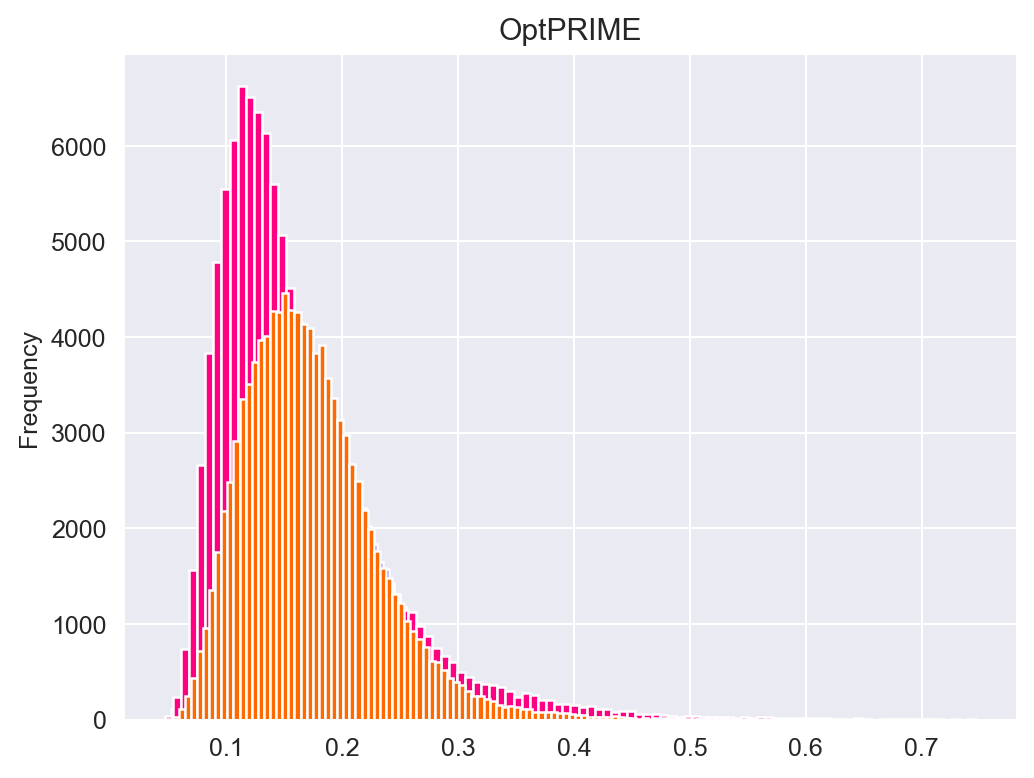

In [315]:
train_dataset=cedar_expr.copy()
scores = []
for encoding_kwargs, ics_dict, cdt in [cdt_general, cdt_cedar, cdt_prime]:
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('\n########\n')
    general_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, hp_preds = evaluate_trained_models_sklearn(hp_merged.drop(index=idx_nan).rename(columns={'icore_similarity_score':'icore_dissimilarity_score'}),
                                           general_models, ics_dict, train_dataframe=None,
                                           encoding_kwargs=encoding_kwargs, concatenated=False, only_concat=False, n_jobs=8)
    mu = hp_preds['mean_pred'].mean()
    sigma = hp_preds['mean_pred'].std()
    hp_preds['mean_pred'].plot(kind='hist', bins=100, title=cdt)

    hp_preds['dataset']='HP'
    hp_preds['cdt'] = cdt
    scores.append(hp_preds[['mean_pred', 'dataset', 'cdt']])
    for evalset, evalname in zip([cedar_expr, prime_expr, nepdb_expr],
                                 ['cedar','prime','nepdb']):
        if not evalset.equals(train_dataset):
            evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               general_models, ics_dict, train_dataset,
                                               encoding_kwargs=encoding_kwargs, concatenated=False, only_concat=False, n_jobs=8)
        preds['z_score']=preds['mean_pred'].apply(get_zscore, mu=mu, sigma=sigma)
        auc_normal = round(roc_auc_score(preds['agg_label'].values, preds['mean_pred'].values), 4)
        auc_zscore = round(roc_auc_score(preds['agg_label'].values, preds['z_score'].values), 4)
        print(cdt,'\t',evalname,'\t',auc_normal,'\t',auc_zscore)
        preds['dataset']=evalname
        preds['cdt']=cdt
        scores.append(preds[['mean_pred', 'z_score', 'dataset', 'cdt']])


########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]


########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]


########



Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

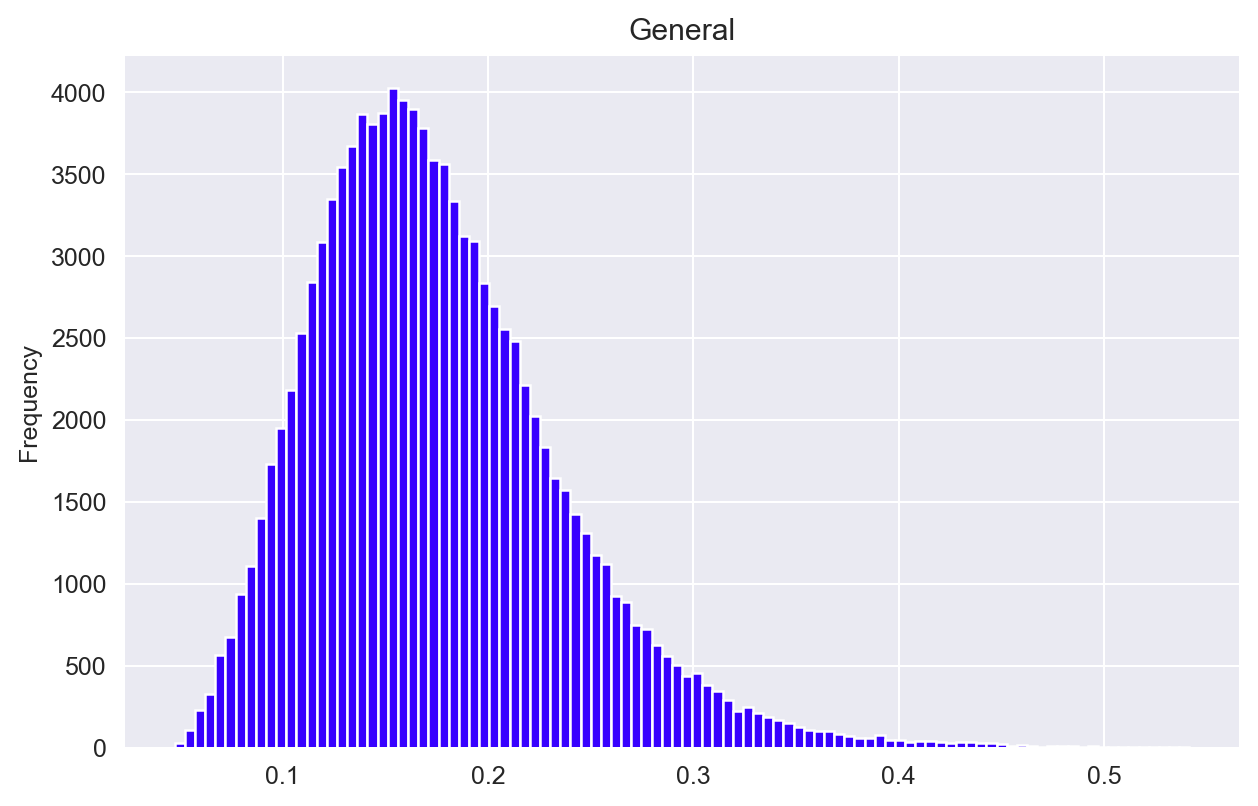

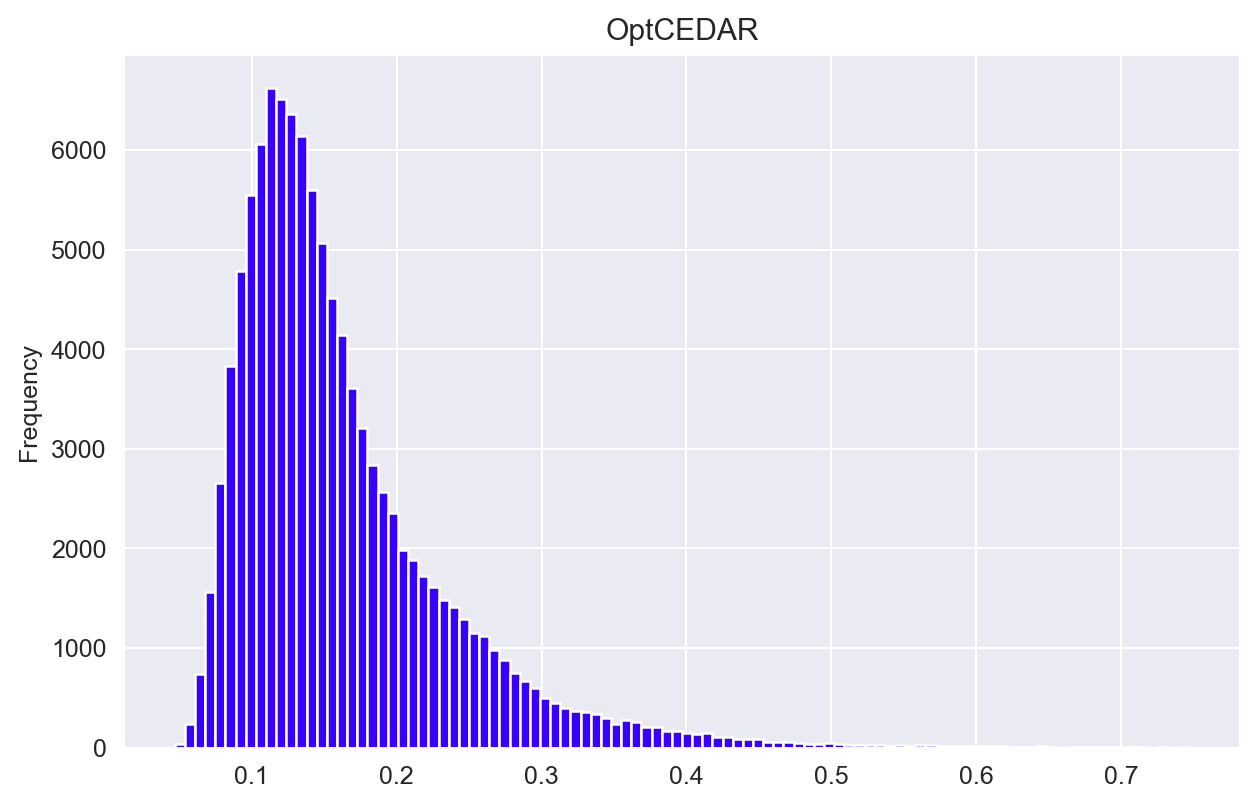

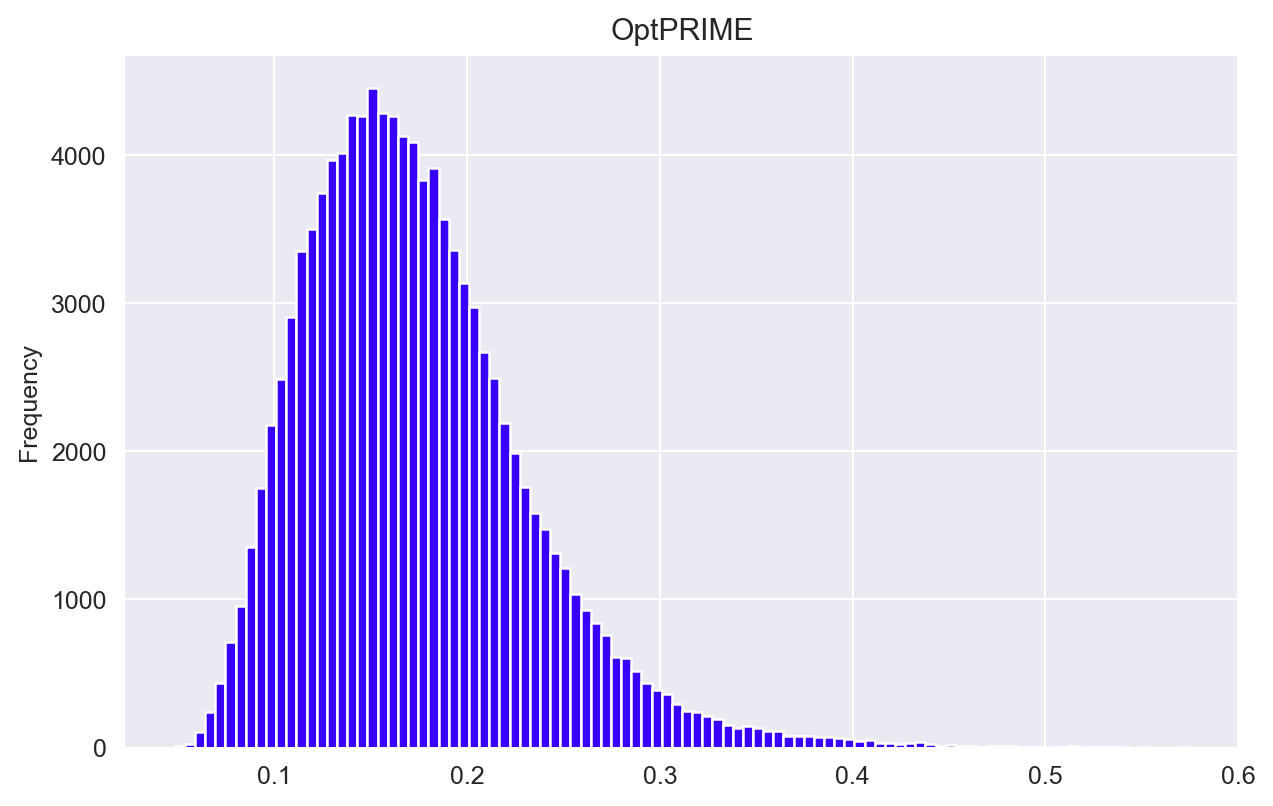

In [316]:
for encoding_kwargs, ics_dict, cdt in [cdt_general, cdt_cedar, cdt_prime]:
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('\n########\n')
    general_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, hp_preds = evaluate_trained_models_sklearn(hp_merged.drop(index=idx_nan).rename(columns={'icore_similarity_score':'icore_dissimilarity_score'}),
                                           general_models, ics_dict, train_dataframe=None,
                                           encoding_kwargs=encoding_kwargs, concatenated=False, only_concat=False, n_jobs=8)
    mu = hp_preds['mean_pred'].mean()
    sigma = hp_preds['mean_pred'].std()
    f,a = plt.subplots(1,1,figsize=(8,5))
    hp_preds['mean_pred'].plot(kind='hist', bins=100, title=cdt, ax=a)

In [317]:
zscores = pd.concat(scores)

In [318]:
del general_models, hp_preds

# Expand Ensemble

In [134]:
expand_df = pd.read_csv('../output/230405_ExpandEnsembleResample/total_df.csv')

In [136]:
expand_df.groupby(['evalset', 'condition', 'expand']).agg(mean_auc=('auc','mean'),
                                                          mean_auc01=('auc_01','mean'),
                                                          mean_ap=('AP','mean'))

mean_auc  mean_auc01   mean_ap
evalset condition expand                                
CEDAR   Base      False   0.699159    0.565206  0.385126
                  True    0.699438    0.566063  0.386436
        General   False   0.726263    0.574859  0.415562
                  True    0.725738    0.574256  0.413937
        OptCEDAR  False   0.741284    0.583194  0.442828
                  True    0.741697    0.583301  0.442578
        OptPRIME  False   0.709356    0.565538  0.398245
                  True    0.709412    0.566620  0.399684
NEPDB   Base      False   0.589944    0.521503  0.168133
                  True    0.590936    0.522870  0.168920
        General   False   0.737243    0.594229  0.313166
                  True    0.739949    0.596782  0.317092
        OptCEDAR  False   0.694603    0.545857  0.217941
                  True    0.695097    0.543301  0.216755
        OptPRIME  False   0.716671    0.615072  0.309632
                  True    0.716430    0.615072  0.309958
PRIME   Base      False   0.677925    0.543853  0.036933
                  True    0.677315    0.544338  0.037084
        General   False   0.712794    0.579884  0.069755
                  True    0.712851    0.580412  0.070548
        OptCEDAR  False   0.650914    0.522125  0.053649
                  True    0.652116    0.521987  0.053736
        OptPRIME  False   0.729706    0.594233  0.081193
                  True    0.728686    0.594205  0.081528

In [440]:
expand_df.head()

,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,condition,expand,evalset
0,0.733425,0.387213,0.390035,0.563693,0.032841,0.802878,0.555556,0.016920,General,True,CEDAR
1,0.723443,0.385646,0.388414,0.566848,0.023529,0.805556,0.500000,0.012048,General,True,CEDAR
2,0.735118,0.399953,0.403435,0.577045,0.036789,0.807229,0.687500,0.018900,General,True,CEDAR
3,0.729472,0.433336,0.436459,0.582260,0.046154,0.792503,0.789474,0.023772,General,True,CEDAR
4,0.721009,0.397862,0.401689,0.569593,0.038035,0.796854,0.666667,0.019576,General,True,CEDAR


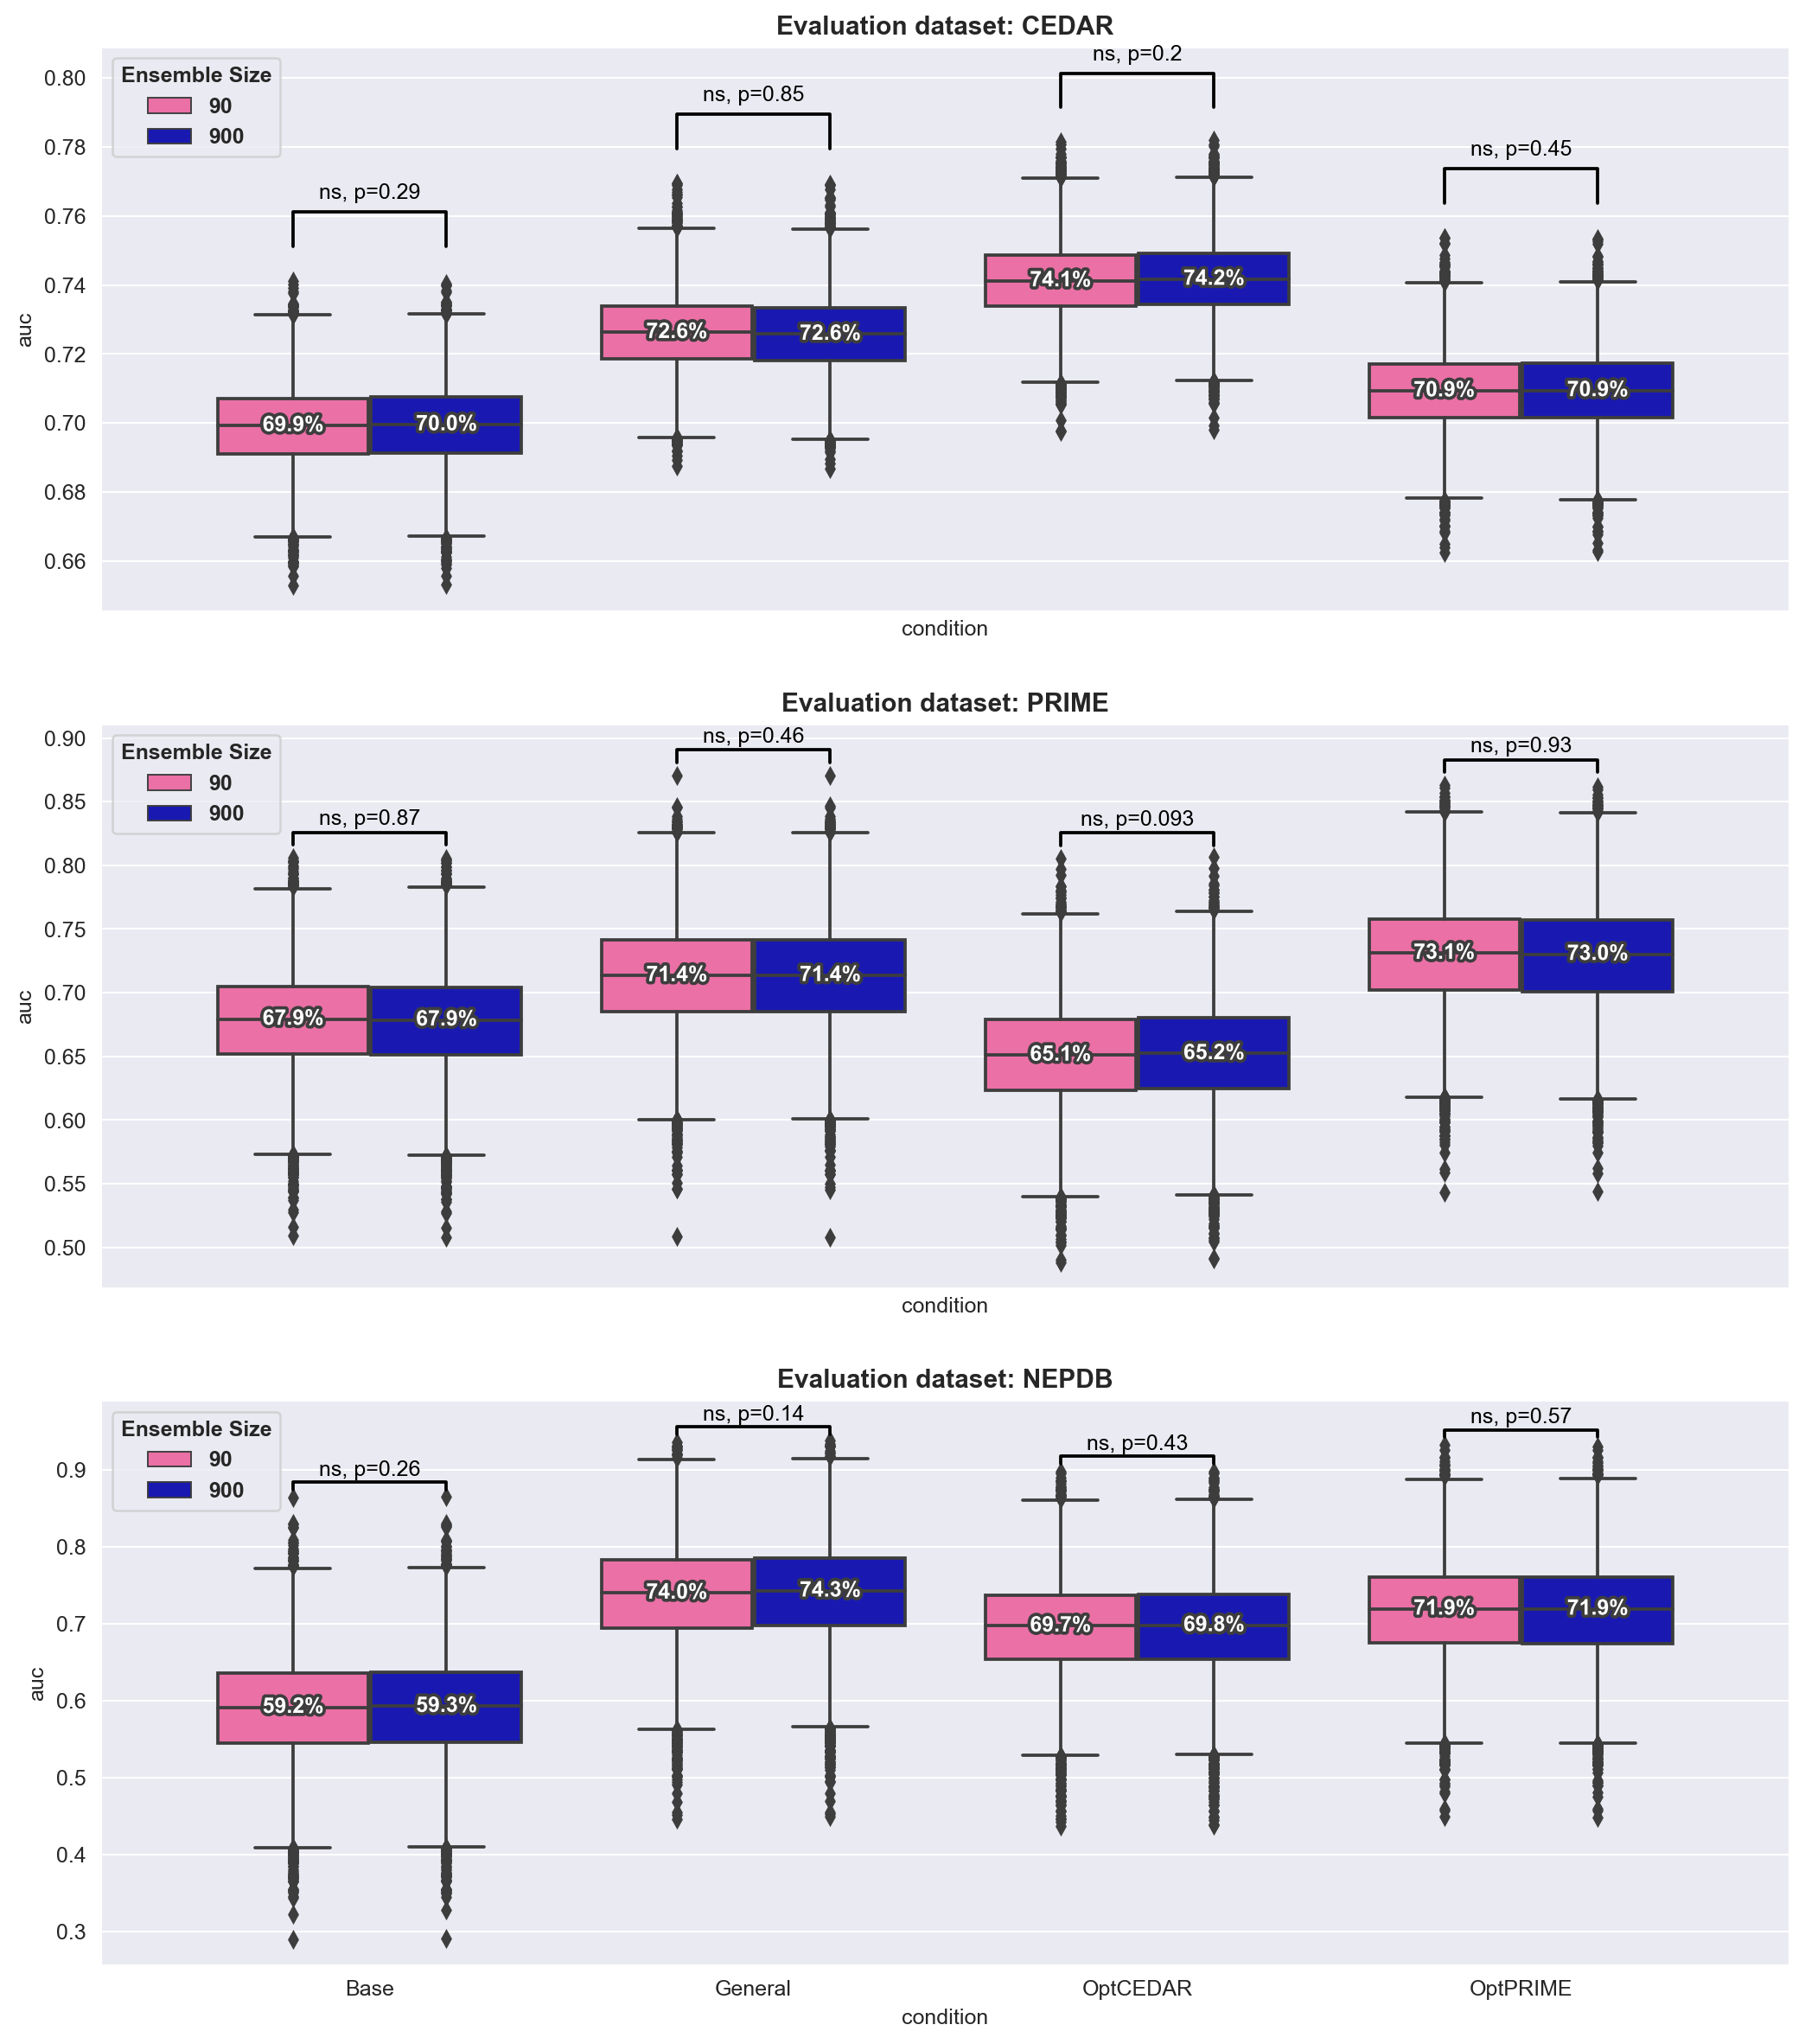

In [467]:
from src.bootstrap import get_pval, plot_pval
sns.set_palette(get_palette('gnuplot2_r', 2))
f,a = plt.subplots(3,1, figsize=(14,16), sharex=True)
a = a.ravel()

order = ['Base', 'General', 'OptCEDAR', 'OptPRIME']
for evalset, axis in zip(expand_df.evalset.unique(), a):
    tmp = expand_df.query('evalset==@evalset')
    tmp['EnsembleSize'] = tmp['expand'].apply(lambda x: 900 if x else 90)
    sns.boxplot(data=tmp, x = 'condition', y='auc', hue='EnsembleSize', ax= axis, order=order)
     # X0 (CEDAR) pvals
    dx = .8/2 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    for x0 in range(len(order)):
        cdt = order[x0]
        aucs_base = tmp.query('condition == @cdt and not expand').auc.values
        aucs_expand = tmp.query('condition == @cdt and expand').auc.values
        h, h0 = 0.01, 0.0125
        pval, sig = get_pval(aucs_expand, aucs_base)
        x1, x2 = x0-dx/2, x0+dx/2
        plot_pval(axis, pval, sig, x1, x2, y=max(aucs_base)+h,h=h0, color='k')
    axis.set_title(f'Evaluation dataset: {evalset}', fontweight='semibold')
    axis.legend(loc='upper left', prop={'weight':'semibold'}, title='Ensemble Size',
                title_fontproperties={'weight':'semibold'})
    add_median_labels(axis)
f.savefig('../../../writing/230131_cedar_paper_1/figures/2304XX_expand_ensemble.png', dpi=200,
          bbox_inches='tight')

# Viral peps

In [402]:
viral_df = pd.read_csv('../output/230401_viral_featimp_sampling_interative/feat_imps_df.csv')

In [ ]:
viral_df.columns

Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V', 'rank', 'ProportionViral', 'NpepViral',
       'Weight', 'seed', 'Proportion Viral', 'Tryptophan (W) Feat. Importance',
       'kcv_auc', 'neoepi_auc'],
      dtype='object')

In [405]:
viral_df['Proportion Viral'] = viral_df.apply(lambda x: f"{x['ProportionViral']/100:.1%}", axis=1)
viral_df['Tryptophan (W) Feat. Importance'] = viral_df.apply(lambda x: 100*x['W'], axis=1)
viral_df.groupby(['Proportion Viral', 'Weight']).agg(mean_W_imp=('W','mean'))

mean_W_imp
Proportion Viral Weight                      
0.0%             Inverted-Shannon    0.009582
                 Mask                0.020621
                 None                0.016073
16.7%            Inverted-Shannon    0.013788
                 Mask                0.024851
...                                       ...
81.8%            Mask                0.081244
                 None                0.071505
9.1%             Inverted-Shannon    0.012014
                 Mask                0.022764
                 None                0.018023

[138 rows x 1 columns]

0        0.0
1        9.1
2       16.7
3       23.1
4       28.6
        ... 
1375    80.4
1376    80.8
1377    81.1
1378    81.5
1379    81.8
Name: Proportion Viral, Length: 1380, dtype: float64

In [ ]:
tm = sorted(viral_df['PropViral'].unique())
xticks = tm[:22] + tm[22::5] + x
xticks

([0.0,
  9.1,
  16.7,
  23.1,
  28.6,
  33.3,
  37.5,
  41.2,
  44.4,
  47.4,
  50.0,
  52.4,
  54.5,
  56.5,
  58.3,
  60.0,
  61.5,
  63.0,
  64.3,
  65.5,
  66.7,
  67.7,
  68.7,
  73.0,
  76.2,
  78.7,
  80.8,
  81.8],
 28)

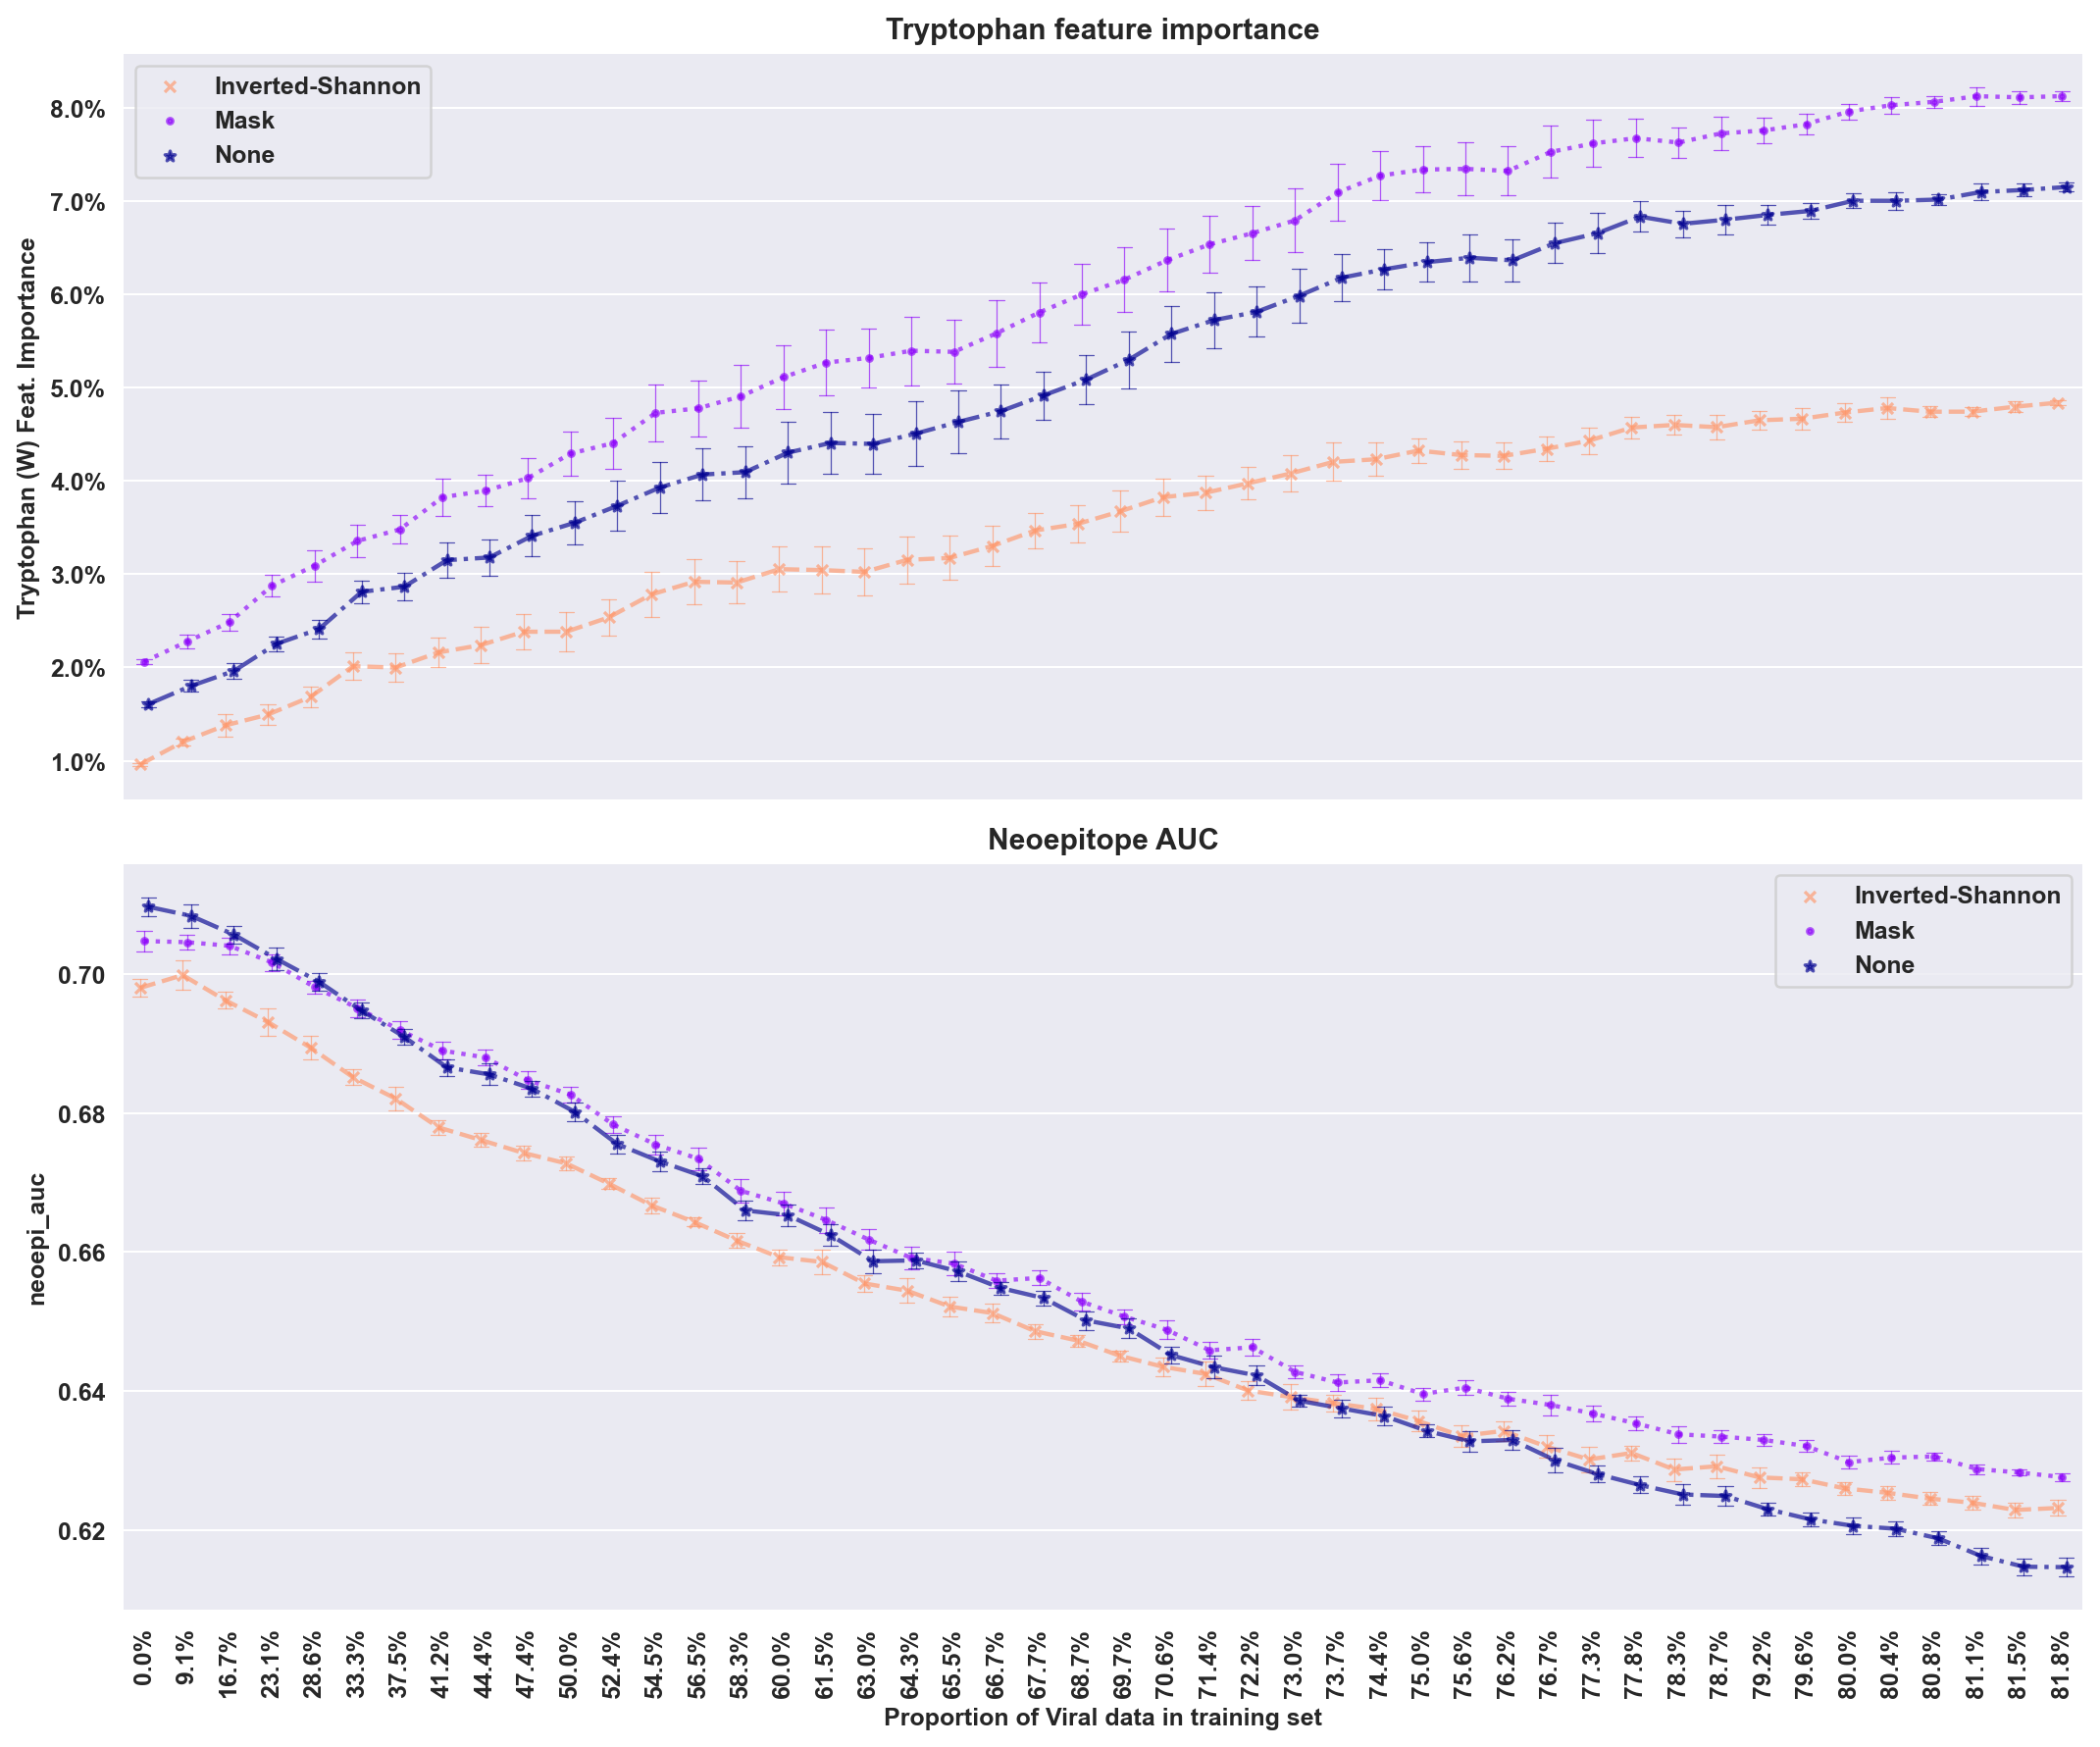

In [562]:
from src.utils import get_palette
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2_r', 3))
viral_df['PropViral'] = viral_df['Proportion Viral'].apply(lambda x: float(x[:-1]))
sns.pointplot(data=viral_df, x='Proportion Viral', y = 'Tryptophan (W) Feat. Importance', hue='Weight', ax=a[0],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])
plt.setp(a[0].patches, alpha=0.75)
plt.setp(a[0].lines, alpha=0.65)
plt.setp(a[0].collections, alpha=0.65)

sns.pointplot(data=viral_df, x='Proportion Viral', y = 'neoepi_auc', hue='Weight', ax=a[1],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])

plt.setp(a[1].patches, alpha=0.75)
plt.setp(a[1].lines, alpha=0.65)
plt.setp(a[1].collections, alpha=0.65)
a[1].legend(loc='upper right', prop={'weight':'semibold'})#,frameon=False)
a[0].legend(loc='upper left', prop={'weight':'semibold'})
a[0].set_xlabel('')
a[1].set_xlabel('Proportion of Viral data in training set', fontweight='semibold',fontsize=10)


a[1].set_xticklabels(a[1].get_xticklabels(), rotation=90, ha='center', va='top', fontweight='semibold')#, pad=.5);

vals = a[0].get_yticks()
a[0].set_yticklabels([f'{x}%' for x in vals], fontweight='semibold');
a[1].set_yticklabels([f'{x:.2f}' for x in a[1].get_yticks()], fontweight='semibold');
a[0].set_ylabel(a[0].get_ylabel(), fontweight='semibold')
a[1].set_ylabel(a[1].get_ylabel(), fontweight='semibold')

a[0].set_title('Tryptophan feature importance', fontweight='semibold', fontsize=12)
a[1].set_title('Neoepitope AUC', fontweight='semibold', fontsize=12)
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230408_viral_analysis', dpi=200, bbox_inches='tight')

# Dataset stats stuff

## HLA ratios

In [399]:
hla_prop=(cedar_expr.groupby(['HLA']).agg(count=('Peptide','count')).sort_values('count',ascending=False) / len(cedar_expr) * 100).rename(columns={'count':'percentage'})
hla_prop['cumsum'] = hla_prop['percentage'].cumsum(axis=0)

In [401]:
hla_prop.head(10)

,percentage,cumsum
HLA,,
HLA-A0201,38.353414,38.353414
HLA-B0702,10.073628,48.427041
HLA-A2402,9.705489,58.132530
HLA-A1101,8.232932,66.365462
HLA-A0301,5.287818,71.653280
HLA-B1501,4.886212,76.539491
HLA-B3501,3.614458,80.153949
HLA-B2705,1.773762,81.927711
HLA-B0801,1.271754,83.199465


## Expression vlues

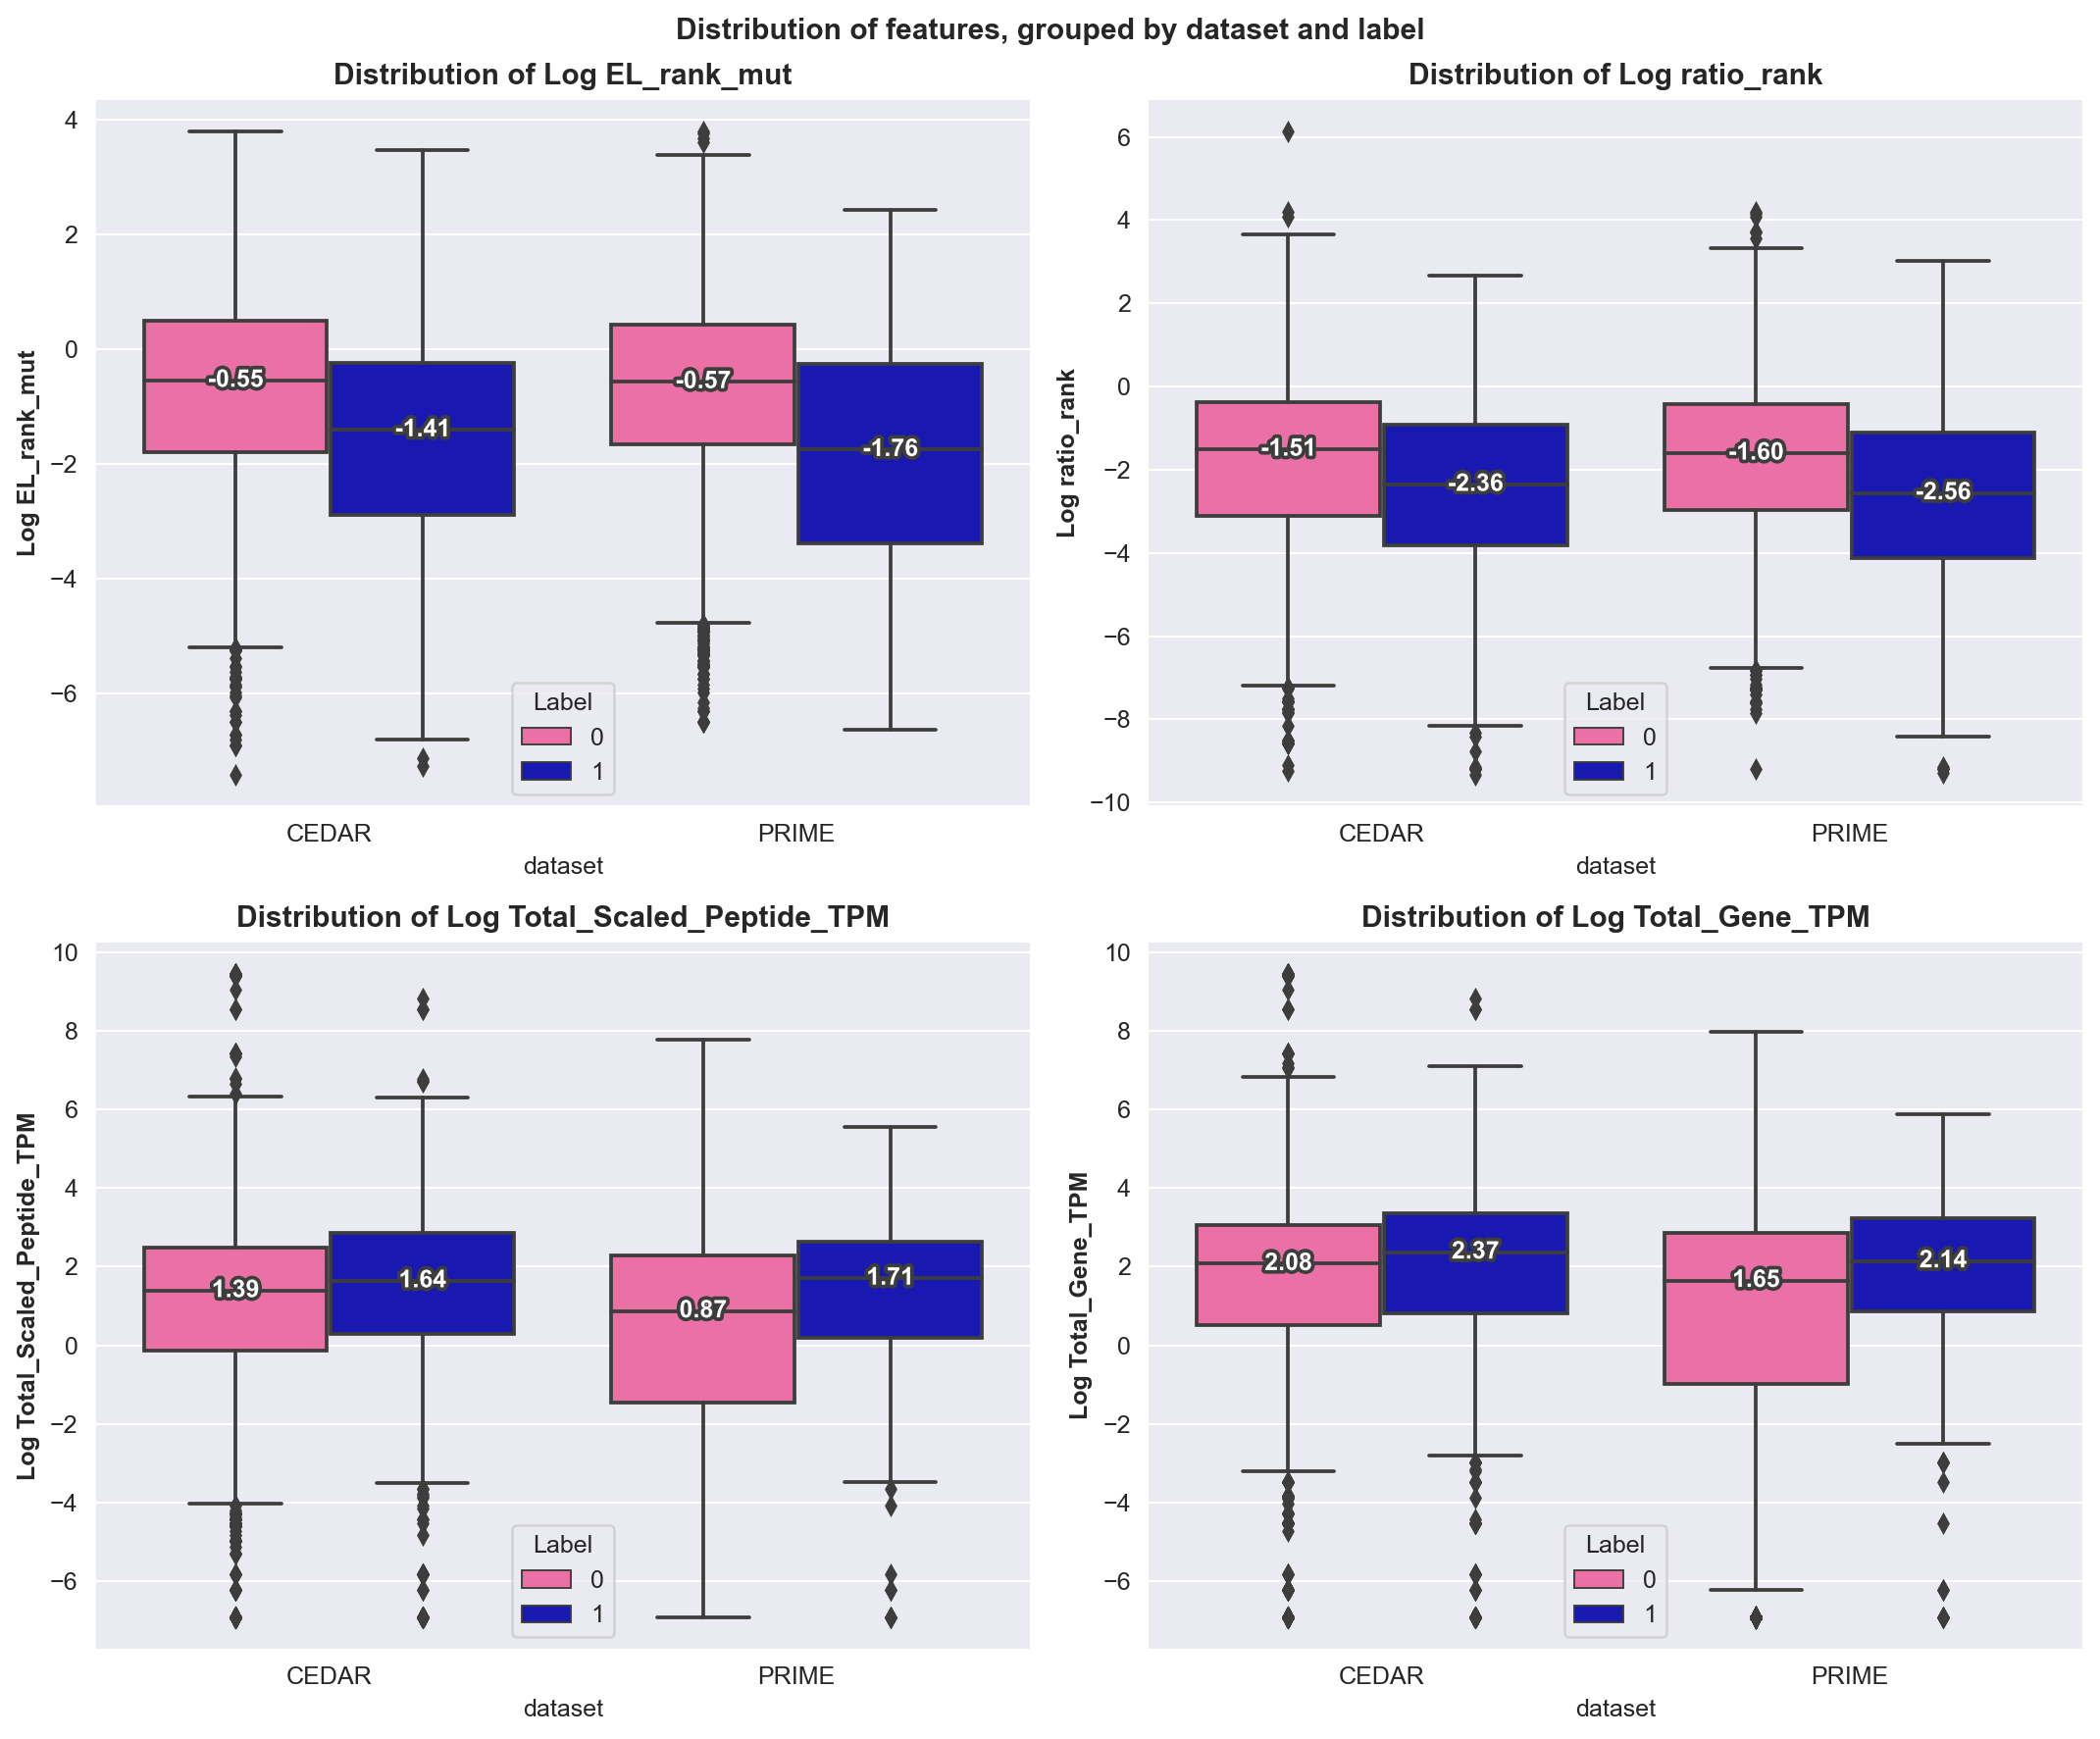

In [513]:
concat_cols = ['HLA', 'agg_label', 'Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank']+['Total_Peptide_TPM', 'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM','dataset']
concat_stat = pd.concat([cedar_expr.assign(dataset='CEDAR')[concat_cols], prime_expr.assign(dataset='PRIME')[concat_cols]])
f,a = plt.subplots(2,2, figsize=(12,10))
for var, ax in zip(['EL_rank_mut', 'ratio_rank', 'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM'],
                   a.ravel()):
    concat_stat[f'Log_{var}'] = concat_stat[var].apply(lambda x: np.log(x))
    sns.boxplot(data=concat_stat, y=f'Log_{var}', x='dataset', hue='agg_label', ax=ax)
    ax.set_title(f'Distribution of Log {var}', fontweight='semibold')
    ax.set_ylabel(f'Log {var}', fontweight='semibold')
    ax.legend(loc='lower center', title='Label')
    add_median_labels(ax, fmt='.2f')
f.suptitle('Distribution of features, grouped by dataset and label', fontweight='semibold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/2304XX_Distribution_Of_Feature_PerLabel')

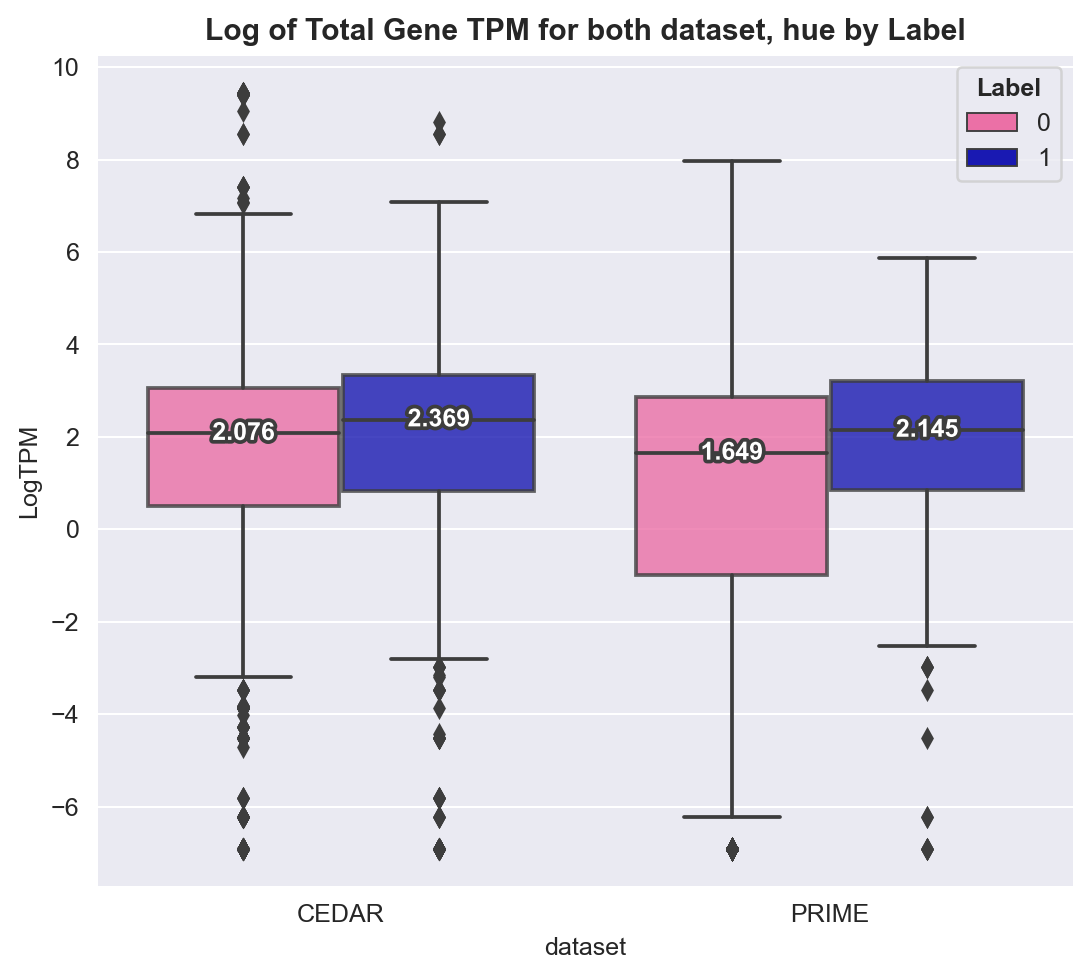

In [497]:
f,a = plt.subplots(1,1, figsize=(7,6))
concat_stat['LogTPM'] = concat_stat['Total_Gene_TPM'].apply(lambda x: np.log(x))
sns.boxplot(data=concat_stat, x='dataset', hue='agg_label', y='LogTPM', ax=a)
a.set_title('Log of Total Gene TPM for both dataset, hue by Label', fontweight='semibold')
a.legend(title='Label', title_fontproperties={'weight':'semibold'})
add_median_labels(a, fmt='.3f')
plt.setp(a.patches, alpha=.8)
f.savefig('../../../writing/230131_cedar_paper_1/figures/2304XX_LogTPM_per_label')